# Cognitive Neuroscience: Project 2022

## Final Project Code Instructions

Marijn van Wingerden, Department of Cognitive Science and Artificial Intelligence – Tilburg University Academic Year 21-22

## Handing in of your code

You can adapt this script template and hand it in as the code component of your Group Assignment Report.

Whenever you are asked to make a plot, it should be completed with a meaningful plot title, xlabel and ylabel texts. Figures are started with a Matplotlib figure handle: "fig_Q2A, ax = plt.subplots;". This indicates that a link (called handle) to your figure will be saved in the variable, so we can easily check it when checking your scripts. Whenever a naming convention for a variable is given, use it, because it will allow semi-automatic grading of your project script.

## Setting up: list your modules to import
For loading/saving puroposes, we will make use of the **os** package.
An example worksheet with instructions on how to use the os package will be provided

In [14]:
%matplotlib notebook

import os
import numpy as np
from pprint import pprint
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.fft as fft
plt.rcParams.update({'font.size': 8}) # we want stuff to be visible

## Data loading

In your assignment, you will compare neural data in different trial conditions from the same participant: this is a *within-subject* comparison. You can think of this as a contrast: which spectral features are more present in condition A vs. condition B?

The second level of the analysis focuses on group statistics. You will answer a question like: "As a group, do the participants in group [RM/RB/RL] show more spectral power in the [delta/theta/alpha/beta/gamma] band in the ambiguous sentences vs. the non-ambiguous sentences?"

The analysis will start with setting up data structures (refer to WorkSheet 0) that will hold the relevant data. Because EEG activity can differ between participants (due to e.g. anatomical differences like skull thickness or skin conductivity), the **absolute** voltages that we record are not completely informative. Instead, we will be looking at **relative** differences within an individual to remove the between-subject effects that we cannot control. 

Each datafile that you have been given has the trials related to a particular condition (NA-IR and AM-IR, for example). "Control" refers to the non-ambiguous conditions, and "Experimental" to the ambiguous condition. 
Please note that the SF and OF trial types have been ignored (that is, added together). The datafiles are NumPy arrays that have been saved to disk. These arrays are 3D arrays: 
- the 0 dimension is the trial repetitions
- the 1st dimension is the number of channels
- the 2nd dimension if the number of samples in a trial
    - for the baseline, this is 0.5s of data (251 samples)
    - for the evoked period, this is 1.5s of data (751 samples)

You will need to load the datafiles from all participants and add them all together so that we end up with a 4D matrix that has nParticipants x nTrials x nChannels x nTime. You can make your work easier by organising the datafiles in such a way that you put the control.npy files in their own subdirectory, and the experimental.npy files as well. 

In order to load the files, we can use the os package.

Adapt the following so that it works on your machine:

In [15]:
# enter the path to the base directory where the folder called group_xx is located
path_base = os.path.normpath('/Volumes/GoogleDrive/My Drive/Tilburg/Year 2/Spring 2022/Cognitive Neuroscience/Group project')

In [16]:
group = 'group_22'

#  path_base + group
path_data = os.path.join(path_base,group)
files = os.listdir(path_data)
control_files = list()
experimental_files = list()
control_files_baseline = list()
experimental_files_baseline = list()


for f in files:
	# check the files that end with specific extention 
    # if a given file would need to be excluded, this is how to do it
    #if f.rfind("part_10") > -1:
    #    continue
    if f.endswith("control.npy"):
        control_files.append(f)
    elif f.endswith("experimental.npy"):
        experimental_files.append(f)
    elif f.endswith("control_baseline.npy"):
        control_files_baseline.append(f)
    elif f.endswith("experimental_baseline.npy"):
        experimental_files_baseline.append(f)
            

# check that the length of your files list matches the provided datafiles, and contains only .npy datafiles

## EVOKED files
control_files.sort()
pprint(control_files)
print("the number of control files is: ", len(control_files), "\n")
experimental_files.sort()
pprint(experimental_files)
print("the number of experimental files is: ", len(experimental_files), "\n")

## BASELINE files
control_files_baseline.sort()
pprint(control_files_baseline)
print("the number of baseline control files is: ", len(control_files_baseline), "\n")
experimental_files_baseline.sort()
pprint(experimental_files_baseline)
print("the number of baseline experimental files is: ", len(experimental_files_baseline), "\n")

['group_22_part_01_control.npy',
 'group_22_part_02_control.npy',
 'group_22_part_03_control.npy',
 'group_22_part_04_control.npy',
 'group_22_part_05_control.npy',
 'group_22_part_06_control.npy',
 'group_22_part_07_control.npy',
 'group_22_part_08_control.npy',
 'group_22_part_09_control.npy',
 'group_22_part_10_control.npy',
 'group_22_part_11_control.npy',
 'group_22_part_12_control.npy',
 'group_22_part_13_control.npy',
 'group_22_part_14_control.npy',
 'group_22_part_15_control.npy']
the number of control files is:  15 

['group_22_part_01_experimental.npy',
 'group_22_part_02_experimental.npy',
 'group_22_part_03_experimental.npy',
 'group_22_part_04_experimental.npy',
 'group_22_part_05_experimental.npy',
 'group_22_part_06_experimental.npy',
 'group_22_part_07_experimental.npy',
 'group_22_part_08_experimental.npy',
 'group_22_part_09_experimental.npy',
 'group_22_part_10_experimental.npy',
 'group_22_part_11_experimental.npy',
 'group_22_part_12_experimental.npy',
 'group_22_

## Combining data and matrix pre-allocation
next, you will need to load these files one by one and extract the data for this participant. 
The data in the NumPy arrays are stored as Trials x Channels x Time. To aggregate across participants, you will thus need to add a 4th dimension to store the data.

To be able to adequately pre-allocate the data from the different subjects, we will load one trial subject manually to have a look at the shape/dimensionality of the data:

In [17]:
EEG = np.load(os.path.join(path_data,control_files[0]))
              
# control_files is a list of strings, so indexing its first element returns a string
# in this case, we are loading the first entry of control_files, i.e. participant 1

# verify that the number of trials equals 44, 
# verify that the number of channels equals 64 or 65 
# and verify that there are 751 samples per trace

print("Number of trials = ", EEG.shape[0])
print("Number of channels = ", EEG.shape[1])
print("Number of timepoints = ", EEG.shape[2])

# do the same for one of the baseline datafiles (they have a different number of samples)

EEG_base = np.load(os.path.join(path_data,control_files_baseline[0]))

print("Number of trials (base) = ", EEG_base.shape[0])
print("Number of channels  (base) = ", EEG_base.shape[1])
print("Number of timepoints (base) = ", EEG_base.shape[2])

Number of trials =  44
Number of channels =  64
Number of timepoints =  751
Number of trials (base) =  44
Number of channels  (base) =  64
Number of timepoints (base) =  276


## Q1 - setting up the data structure and loading data from all participants

The EEG data is currently stored as a 3-dimensional NumPy array. But to run our time-frequency analysis, we need some more information like the sampling rate and the time axis that corresponds to the stimulus-locked analysis window. In order to set up (=pre-allocate) a matrix that will hold all traces for all participants, we need to know the sizes of the dimensions of this 4-dimensional matrix, and fill up this matrix by looping over participants:

- Subset EEG and EEG_base so that only the first 59 channels remain
    - as a result the shape of the channel dimension should be 59 after this step
- Define the following quantities by extracting them from loaded EEG files or file lists
    - nTrials
    - nChans
    - nSamples
    - nSamples_base
    - nParticipants

In [18]:
# There are 64 or 65 channels in the dataset. Only channels 1-59 (not python indexes!) are EEG channels
# the remaining channels are EMG and EOG channels that we will ignore in this analysis
# subset your EEG array so that only the EEG channels remain

# subset EEG to the first 59 channels
EEG = EEG[:,:59,:]
# subset EEG_base to the first 59 channels
EEG_base = EEG_base[:,:59,:]
print(EEG.shape)

# Define nTrials, nChans (=channels), nSamples, nSamples_base and nParticipants.
# Refer to the shape/length of existing variables
nTrials = EEG.shape[0]
nChans = EEG.shape[1]
nSamples = EEG.shape[2]
nSamples_base = EEG_base.shape[2]
nParticipants = len(control_files)

# Then, pre-allocate a matrix filled with zeros and with size nParticipants x nTrials x nChans x nSamples
# one each for the control, experimental, control_baseline and experimental_baseline data. 
# Name them 
# data_control 
# data_experimental
# data_control_base
# data_experimental_base

data_control = np.zeros((nParticipants, nTrials , nChans, nSamples))
data_experimental = np.zeros((nParticipants, nTrials , nChans, nSamples))
data_control_base = np.zeros((nParticipants, nTrials , nChans, nSamples_base))
data_experimental_base = np.zeros((nParticipants, nTrials , nChans, nSamples_base))


# next, we need to loop over all participant datafiles and add them to the appropriate slice in your 4-D arrays
# For this, you need to use specific array indexing to indicate where in the data arrays
# each participant's data needs to go. You can and should reuse the data-reading code above.

# CAREFUL! Not every participant may have the same number of (correct) trials in their dataset. 
# So for each newly loaded datafile, you need to establish the current number of trials again

# loop over participants, and within each iteration of the loop, load the
# next datafile and fill the data arrays with the EEG traces (nTrials x nChans x nSamples)
# check the shape of the matrices after filling them

for iPart in range(nParticipants):
    EEG = np.load(os.path.join(path_data,control_files[iPart]))[:,:59,:]
    curr_Trials = EEG.shape[0]
    curr_Chans = EEG.shape[1]
    curr_Samples = EEG.shape[2]
    data_control[iPart,:curr_Trials,:curr_Chans,:curr_Samples] = EEG
    EEG = np.load(os.path.join(path_data,experimental_files[iPart]))[:,:59,:]
    curr_Trials = EEG.shape[0]
    curr_Chans = EEG.shape[1]
    curr_Samples = EEG.shape[2]
    data_experimental[iPart,:curr_Trials,:curr_Chans,:curr_Samples] = EEG
    
    EEG = np.load(os.path.join(path_data,control_files_baseline[iPart]))[:,:59,:]
    curr_Trials = EEG.shape[0]
    curr_Chans = EEG.shape[1]
    curr_Samples_base = EEG.shape[2]
    data_control_base[iPart,:curr_Trials,:curr_Chans,:curr_Samples_base] = EEG
    EEG = np.load(os.path.join(path_data,experimental_files_baseline[iPart]))[:,:59,:]
    curr_Trials = EEG.shape[0]
    curr_Chans = EEG.shape[1]
    curr_Samples_base = EEG.shape[2]
    data_experimental_base[iPart,:curr_Trials,:curr_Chans,:curr_Samples_base] = EEG
    
print("Shape of data_control:",data_control.shape)
print("Shape of data_experimental:",data_experimental.shape)
print("Shape of data_control_base:",data_control_base.shape)
print("Shape of data_experimental_base:",data_experimental_base.shape)

(44, 59, 751)
Shape of data_control: (15, 44, 59, 751)
Shape of data_experimental: (15, 44, 59, 751)
Shape of data_control_base: (15, 44, 59, 276)
Shape of data_experimental_base: (15, 44, 59, 276)


## Q2 - explore the data

Let's explore this newly combined dataset a little bit. You now have four collections of EEG traces as datasets: 
- an evoked period around the critical item for NA trials
- the corresponding baseline period from each of those trials
- an evoked period around the critical item for AM trials
- the corresponding baseline period from each of those trials

Each dataset has an equal number of trials, which is linked to the design, but in principle there could be more or less trials in one condition compared to the other. However, the Evoked and Base data is always taken from the *same* trial, so they should come in equal numbers.

For both periods in the trial, the EEG trace voltage values have been 'baselined', which in this case means that the mean of a designated baseline period has been subtracted from all values, so that the mean over the baseline part of each period is 0 (with some rounding error. 
- For the Base period, the baseline has been calculated over the interval -0.05s (= -50 ms) to the 0 index. 
- For the Evoked period, the baseline has been calculated over the interval -0.5s (= -500ms) to the 0 index.

### set the time axes

Let's start by setting the time index correctly for the base and the evoked periods. Given that the srate = 500 Hz, define time_base and time_evoked as vectors that that match times from the start- to the endpoints of the Base and Evoked periods, respectively. NOTE: you will have seen that the number of samples is one more than you might expect based on the time duration and the sampling rate. This is because both the start and endpoints are included. Here, using linspace is preferred over np.arange




In [19]:
srate = 500
sample_step = 1/srate

# use np.linspace
time_base = np.linspace(start = -0.05, stop = 0.5, num= nSamples_base)
time_evoked = np.linspace(start = -0.5, stop = 1.0, num= nSamples)

print("shape of the time_base axis:",time_base.shape)
print("shape of the time_evoked axis:",time_evoked.shape)
print("last sample of time_base:", time_base[-1])
print("last sample of time_evoked:", time_evoked[-1])

shape of the time_base axis: (276,)
shape of the time_evoked axis: (751,)
last sample of time_base: 0.5
last sample of time_evoked: 1.0


### plot the ERPs

If the baselining procedure worked out fine, it should be possible to see this 0-average in the ERP plots for an arbitrary channel and participant.

Start by making a figure with 1x2 (1 row, 2 column) subplots. For your ERP, select a random participant from your data, and a random channel. For this particular channel:
- make a time vs ERP plot for the baseline period in the 1st subplot
    - plot the NA ERP in one color, and the AM ERP in another
- make a time vs ERP plot for the evoked period in the 2nd subplot
    - plot the NA ERP in one color, and the AM ERP in another
- provide proper annotation (subplot title, line label, x- and y-axis labeling
- draw a vertical line at the t=0s mark in both plots
    - to draw a vertical line in the first subplot, at the appropriate scale, use:
    - ax[0].plot([0,0], np.array([-3,3])*np.float_power(10,-6), 'k')
    - adjust the float_power parameters to fit your ERP if necessary

(44, 276)
(276,)


<IPython.core.display.Javascript object>


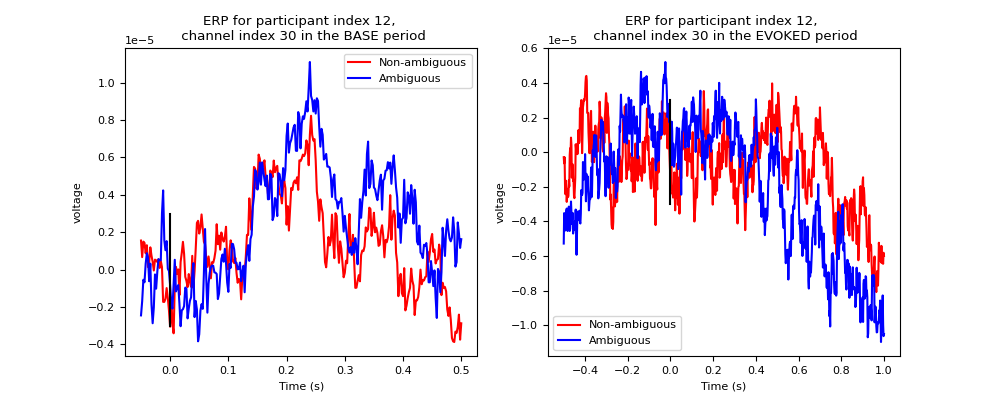

In [20]:
random_part = 12
random_channel = 30

traces_base_NA = data_control_base[random_part, :, random_channel, :]
traces_base_AM = data_experimental_base[random_part, :, random_channel, :]
traces_evoked_NA = data_control[random_part, :, random_channel, :]
traces_evoked_AM = data_experimental[random_part, :, random_channel, :]

print(traces_base_NA.shape)
ERP_base_NA = np.mean(traces_base_NA, axis = 0)
ERP_base_AM = np.mean(traces_base_AM, axis = 0)
ERP_evoked_NA = np.mean(traces_evoked_NA, axis = 0)
ERP_evoked_AM = np.mean(traces_evoked_AM, axis = 0)
print(ERP_base_NA.shape)

fig_Q2, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2) # 1x2 graph

# plot the baseline ERP traces in ax[0]
ax[0].plot(time_base, ERP_base_NA, 'r', label = 'Non-ambiguous')
ax[0].plot(time_base, ERP_base_AM, 'b', label = 'Ambiguous')
ax[0].plot([0,0], np.array([-3,3])*np.float_power(10,-6), 'k')
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("voltage")
ax[0].set(title = "ERP for participant index {}, \n channel index {} in the BASE period".format(random_part, random_channel))
ax[0].legend()

# plot the Evoked ERP traces in ax[1]
ax[1].plot(time_evoked, ERP_evoked_NA, 'r', label = 'Non-ambiguous')
ax[1].plot(time_evoked, ERP_evoked_AM, 'b', label = 'Ambiguous')
ax[1].plot([0,0], np.array([-3,3])*np.float_power(10,-6), 'k')
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("voltage")
ax[1].set(title = "ERP for participant index {}, \n channel index {} in the EVOKED period".format(random_part, random_channel))
ax[1].legend()

plt.show()






## Q3 - group-level averages on the ERP

Now that we have seen the ERP for the NA and AM condition in both conditions, for a single participant and a single trial, we can expand this analysis to a group-level analysis. Here, we treat all trials from a single participant as an observation, and consider each participant 1 observation in the group-level analysis. The question we want to answer is: do we see ERP within-subject differences beteen the NA and AM conditions that are *consistant* across participants, and thus show up in a group-level analysis. We will focus on both the baseline period and the evoked period

In order to this, we will take the following steps:

- pre-allocate an empty array (using np.zeros) that has the required shape (what is the required shape?) to hold one ERP for a chosen channel per participant:
    - one for group_ERP_baseline_NA
    - one for group_ERP_baseline_AM
    - one for group_ERP_evoked_NA
    - one for group_ERP_evoked_AM
- set up a loop across participants to calculate the ERPs in the 2x2 (periods x conditions) time windows. You can reuse parts of the code for Q2 and extend them
- for each of your group_ERP matrices, calculate the mean ERP (take the mean across the participant dimension)
- for each of your group_ERP matrices, calculate the ERP std (take the standard deviation across the participant dimension
    - refer back to WS0. np.std works quite similar to np.mean

Just as with the mean, taking the SD across an ERP array should give you a vector with the same number of elements as there are time-samples in the ERP. For each timepoint, you now have a mean voltage value (= ERP mean) and the corresponding standard deviation from that distribution. To see if there are significant differences between conditions, a reasonable approach is to visualise how *consistent* the ERP signals are by plotting their mean and a confidence interval that ranges from: mean+1SD until mean-1SD. If we do this for both conditions, the timepoints where those confidence bands **do not** overlap might be parts of the ERP where we could observe significant differences. Running a formal significance test goes beyond the scope of this subquestion. We will use matplotlib's *fill_between* function (https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.fill_between.html) for this. Note that there are three arguments to fill_between:
- the X-axis values
- Y1 and Y2, the y-axis ranges to fill between

Start by making a figure with 1x2 (1 row, 2 column) subplots. For your average ERPs, select the same channel for each time period. For this particular channel:
- make a time vs average ERP plot for the baseline period in the 1st subplot
    - plot the NA ERP in one color, and the AM ERP in another
    - use fill_between to fill an area from +1SD to -1SD around the NA ERP mean
    - do the same for the AM ERP mean
        - set alpha = 0.5 for the fills; use the same color as for plotting the means

- make a time vs average ERP plot for the evoked period in the 2nd subplot
    - plot the NA ERP in one color, and the AM ERP in another
    - use fill_between to fill an area from +1SD to -1SD around the NA ERP mean
    - do the same for the AM ERP mean
        - set alpha = 0.5 for the fills; use the same color as for plotting the means

- provide proper annotation (subplot title, line label, x- and y-axis labeling
- draw a vertical line at the t=0s mark in both plots
    - to draw a vertical line in the first subplot, at the appropriate scale, use:
    - ax[0].plot([0,0], np.array([-3,3])*np.float_power(10,-6), 'k')
    - adjust the float_power parameters to fit your ERP if necessary



(15, 276)


<IPython.core.display.Javascript object>


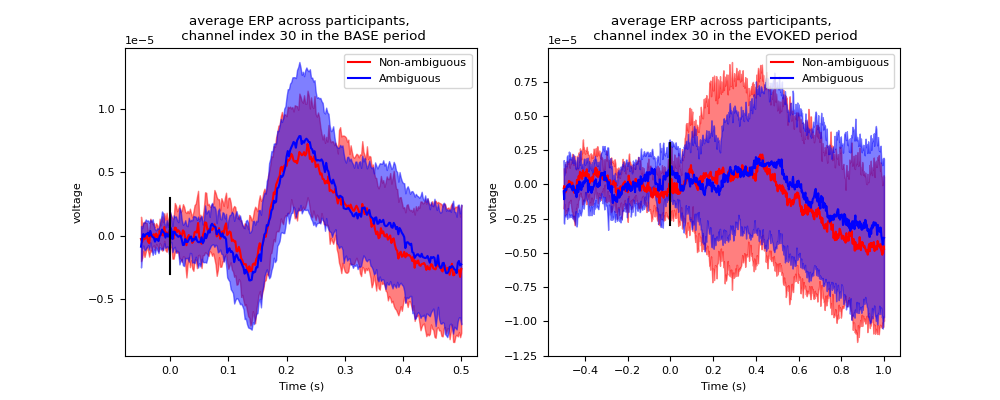

In [21]:
# select a random channel
random_channel = 30

# setup group_ERP datastructurs with zeros
group_ERP_baseline_NA = np.zeros((nParticipants, nSamples_base))
group_ERP_baseline_AM = np.zeros((nParticipants, nSamples_base))
group_ERP_evoked_NA = np.zeros((nParticipants, nSamples))
group_ERP_evoked_AM = np.zeros((nParticipants, nSamples))

#loop across participants - fill up the datastructures
for iPart in range(nParticipants):
    curr_part_traces_base_NA = data_control_base[iPart, :, random_channel, :]
    curr_part_ERP_base_NA = np.mean(curr_part_traces_base_NA, axis = 0) # across the trials
    group_ERP_baseline_NA[iPart,:] = curr_part_ERP_base_NA
    
    curr_part_traces_base_AM = data_experimental_base[iPart, :, random_channel, :]
    curr_part_ERP_base_AM = np.mean(curr_part_traces_base_AM, axis = 0)
    group_ERP_baseline_AM[iPart,:] = curr_part_ERP_base_AM
    
    curr_part_traces_evoked_NA = data_control[iPart, :, random_channel, :]
    curr_part_ERP_evoked_NA = np.mean(curr_part_traces_evoked_NA, axis = 0)
    group_ERP_evoked_NA[iPart,:] = curr_part_ERP_evoked_NA
    
    curr_part_traces_evoked_AM = data_experimental[iPart, :, random_channel, :]
    curr_part_ERP_evoked_AM = np.mean(curr_part_traces_evoked_AM, axis = 0)
    group_ERP_evoked_AM[iPart,:] = curr_part_ERP_evoked_AM
    
# print the shape of an example
print(group_ERP_baseline_NA.shape)

# calculate group_ERP means and SD's
mean_ERP_base_NA = np.mean(group_ERP_baseline_NA, axis = 0)
mean_ERP_base_AM = np.mean(group_ERP_baseline_AM, axis = 0)
mean_ERP_evoked_NA = np.mean(group_ERP_evoked_NA, axis = 0)
mean_ERP_evoked_AM = np.mean(group_ERP_evoked_AM, axis = 0)

std_ERP_base_NA = np.std(group_ERP_baseline_NA, axis = 0)
std_ERP_base_AM = np.std(group_ERP_baseline_AM, axis = 0)
std_ERP_evoked_NA = np.std(group_ERP_evoked_NA, axis = 0)
std_ERP_evoked_AM = np.std(group_ERP_evoked_AM, axis = 0)

# set up the Q3 plot
fig_Q3, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2) # 1x2 graph

# plot the baseline av ERP traces + STD in ax[0]
ax[0].plot(time_base, mean_ERP_base_NA, 'r', label = 'Non-ambiguous')
ax[0].fill_between(time_base, mean_ERP_base_NA+std_ERP_base_NA,mean_ERP_base_NA-std_ERP_base_NA, alpha = 0.5, color = 'r')

ax[0].plot(time_base, mean_ERP_base_AM, 'b', label = 'Ambiguous')
ax[0].fill_between(time_base, mean_ERP_base_AM+std_ERP_base_AM,mean_ERP_base_AM-std_ERP_base_AM, alpha = 0.5, color = 'b')

ax[0].plot([0,0], np.array([-3,3])*np.float_power(10,-6), 'k')
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("voltage")
ax[0].set(title = "average ERP across participants, \n channel index {} in the BASE period".format(random_channel))
ax[0].legend()

# plot the Evoked av ERP traces + STD in ax[1]
ax[1].plot(time_evoked, mean_ERP_evoked_NA, 'r', label = 'Non-ambiguous')
ax[1].fill_between(time_evoked, mean_ERP_evoked_NA+std_ERP_evoked_NA, mean_ERP_evoked_NA-std_ERP_evoked_NA, alpha = 0.5, color = 'r')

ax[1].plot(time_evoked, mean_ERP_evoked_AM, 'b', label = 'Ambiguous')
ax[1].fill_between(time_evoked, mean_ERP_evoked_AM+std_ERP_evoked_AM, mean_ERP_evoked_AM-std_ERP_evoked_AM, alpha = 0.5, color = 'b')

ax[1].plot([0,0], np.array([-3,3])*np.float_power(10,-6), 'k')
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("voltage")
ax[1].set(title = "average ERP across participants, \n channel index {} in the EVOKED period".format(random_channel))
ax[1].legend()

plt.show()


## Q4 - set up the data structure for Time Frequency Analysis

Now that we have explored our data, we can proceed with the Time-Frequency Analysis. Before we can preallocate our TFR matrix for a time-resolved frequency analysis (per trial, channel, participant, and per analysis window), we need to figure out how many analysis windows should be in the final array, based on the window length, the overlap and the number of samples in each EEG trace in the dataset. We also need to know how many fourier coefficients we need to store per analysis window.

We already know what the time axis looks like for both periods:
- from -0.05s to 0.5s in the baseline period
- from -0.5s to 1.0s in the evoked period

As has been explored in the Worksheets, the frequency resolution we can achieve with the FFT depends on the number of samples we analyse in a window. Larger windows mean more frequency resolution (i.e. smaller steps between adjacent frequencies) and smaller windows mean bigger steps between frequencies in the FFT spectrum.

For this analysis, refer to your group assignment
- Groups analysing delta frequencies, your frequency resolution should be 2Hz
- Groups analysing theta frequencies, your frequency resolution should be 2Hz
- Groups analysing alpha frequencies, your frequency resolution should be 2Hz
- Groups analysing beta frequencies, your frequency resolution should be 5Hz
- Groups analysing gamma frequecnies, your frequency resolution should be 5Hz

Let's reproduce some of the information we need to setup the frequency axis:

- Define the sampling rate (save as srate)
- Define the Nyquist frequency (save as nyquist_freq)
- Define N_samples_FFT as the number of samples required to achieve your designed frequency resolution
- Calculate spect_freqs as the index of frequencies that will be analysed with your assigned frequency resolution
- Define nFreq as the number of frequencies (in spect_freqs) that will be analysed

Then, extract the samples from your baseline window that will go into your baseline FFT and thus produce your baseline spectrum. Regardless of your frequency resolution, you will only select 1 window from your baseline period, starting at the sample that reflects 0s (hint: this is NOT sample index 0). 



In [22]:
srate = 500 # sampling freq = 500 Hz.
sample_step = 1/srate 
nyquist_freq = srate/2 # maximum analalysable frequency

# EXAMPLE has a WRONG frequency resolution - ADAPT
freq_res = 2 # should be 2 for delta, theta, alpha; 5 for beta and gamma

# define N_samples_FFT as the number of samples you need for your FFT (integer!)
N_samples_FFT = int(srate/freq_res)
print("the number of samples needed to reach this frequency resolution is:", N_samples_FFT)

spect_freqs = fft.rfftfreq(int(N_samples_FFT), 1 / srate)
print("the first five frequencies we can analyse with this resolution are:", spect_freqs[:5])

nFreq = len(spect_freqs)
print("the number of frequencies we can analyse with this resolution is:", nFreq)


# define base_start as the sample index for time = 0s
# hint: use numpy's argmin
base_start = np.argmin(np.abs(time_base))
print("the analysis window for the baseline window starts at sample:", base_start)

# define window_control_base as the 4D array subset of data_control_base that holds the right samples
window_control_base = data_control_base[:,:,:, base_start:base_start + N_samples_FFT]
print("window_control_base has shape:", window_control_base.shape)

window_experimental_base = data_experimental_base[:,:,:, base_start:base_start + N_samples_FFT]
print("window_experimental_base has shape:", window_experimental_base.shape)

the number of samples needed to reach this frequency resolution is: 250
the first five frequencies we can analyse with this resolution are: [0. 2. 4. 6. 8.]
the number of frequencies we can analyse with this resolution is: 126
the analysis window for the baseline window starts at sample: 25
window_control_base has shape: (15, 44, 59, 250)
window_experimental_base has shape: (15, 44, 59, 250)


## Q5 - preallocating the TFR 5D array

Next, now that we know the size of our analysis window for our baseline spectrum, we can define the timestep between adjacent windows to cover the entirety of the Evoked period. Remember that we want adjacent analysis windows to overlap, so the increase across the time axis is always with a percentage of the length of the analysis window (creating overlap). Our first analysis window start at time index -0.5 (the first sample in the evoked period). The last window starts at some point on the time axis so that it still fits inside the Evoked window (i.e. the last sample of the last window should be at or before 1.0s). 

- Set window_step to 10% of the length of the analysis window to allow sufficient overlap between adjacent analysis windows. If window A starts at sample X, then the next window B starts at sample X+window_step
- create a vector called window_starts that has the starting sample (not time!) of each analysis window. 
    - check your work: as the windows shift by 10% of the window length, the 11th window should start exactly 1 window length after the 1st.
- Define nWindows as the number of analysis windows you will be able to fit in the time axis, considering the timestep between adjacent windows.




Now, we can pre-allocate our final array to hold the Fourier Spectrum for each window analysed. 
- Pre-allocate a zeros-filled TFR matrix with 5 dimensions: 
    - nParticipants x nTrials x nChans x nWindows x nFreq 
    - store as TFR_5D_ctr and TFR_5D_exp
    - add np.nan to the entire matrix. This will fill all positions with NaN initially

In [23]:
# Set window_step to 10% of the length of the analysis window
window_step = N_samples_FFT / 10 
print("the window step size for this frequency resolution is: ", window_step)

# hint: use np.arange to create a vector of window starts
window_starts = np.arange(start= 0, stop = (nSamples - N_samples_FFT), step = window_step, dtype = "int")

# Define nWindows as the number of analysis windows
nWindows = len(window_starts)
print("the number of analysis windows for this frequency resolution is: ", nWindows)

# check your work
print("The 11th window start at sample {} which is {} samples further than the first window start (at sample {})".format(window_starts[10],window_starts[10]-window_starts[0],window_starts[0]))
print("this corresponds exactly to the window size of:", N_samples_FFT)

# define TFR_5D_ctr and add NaN
# nParticipants x nTrials x nChans x nWindows x nFreq 
TFR_5D_ctr = np.zeros((nParticipants, nTrials, nChans, nWindows, nFreq))+np.nan
print("the shape of TFR_5D_ctr is: ", TFR_5D_ctr.shape)

# define TFR_5D_exp and add NaN
# nParticipants x nTrials x nChans x nWindows x nFreq 
TFR_5D_exp = np.zeros((nParticipants, nTrials, nChans, nWindows, nFreq))+np.nan
print("the shape of TFR_5D_exp is: ", TFR_5D_ctr.shape)

the window step size for this frequency resolution is:  25.0
the number of analysis windows for this frequency resolution is:  21
The 11th window start at sample 250 which is 250 samples further than the first window start (at sample 0)
this corresponds exactly to the window size of: 250
the shape of TFR_5D_ctr is:  (15, 44, 59, 21, 126)
the shape of TFR_5D_exp is:  (15, 44, 59, 21, 126)


## Q6 - performing a time-resolved frequency analysis

Now that we have the TFR_5D arrays for both the control and the experimental conditions pre-allocated, we can start to fill this 5D TFR matrix in a quadruple loop with Fourier Spectrum **power** data. Basically, each of entries in the 5D matrix corresponds to a single value from the Fourier Spectrum (e.g. the third frequency from the 1x nFreq complex fourier coefficients vector, reduced to just the amplitude value) window. The FFT calculates all frequencies at once, so the output of the fft will fill the nFreq dimension of your TFR 5D. That means that you will need to calculate such a **power vector** for each level of the other 4 dimensions (so, for each participant, for each channel, for each trial and for each analysis window). Together, this makes up the 5D TFR matrix. To perform the FFT analysis for each analysis window, you need to loop over the other 4 dimensions, hence the quadruple loop.

IMPORTANT: this step ONLY applies to the EVOKED arrays; the baseline arrays only have 1 "window" and will be analysed in a later Q.

Perform the following steps for your control and experimental TFR_5D arrays:

- Loop over nParticipants, nTrials and nChans 
- Inside this nested loop, extract the current EEG trace (the size should be 1x nSamples:
    - store curr_signal_ctr from TFR_5D_ctr as a variable
    - store curr_signal_exp from TFR_5D_exp as a variable

### important: check if signal is present
For some participants and some trials, the signal you want to extract is actually not present. Check if the current trace is not equal to all zeros:
- implement a check to see **if** there is at least one sample in curr_signal_ctr/curr_signal_exp that is not zero

If the current trial **is** all zeros, skip the FFT step for this trial. The powerspectrum should remain NaN for this trial (and all windows in it); by not overwriting the array for that trial, the values will remain NaN

### if there is a signal present

This is the signal we will analyse in the consecutive, overlapping analysis windows inside the fourth loop. 

- Loop over nWindows
- Define curr_start and curr_stop as the sample indices for the current analysis window
    - reuse window_starts from Q5 and use that vector to calculate the window_ends vector
    - these two vectors of course should have the same shape (they represent the start and stop of each window)
- Extract the data from the current window as curr_window
    - check the length: is it indeed as long as N_samples_FFT?

Finally, still inside this fourth nested loop, adapt and perform the FFT analysis from the examples shown in the notebooks. 
- run the FFT
- store the amplitudes for the frequency vector by applying the correct transformation to the (complex) Fourier Coefficients as tmp_ps

This gives you a tmp_ps variable (the current power spectrum) with size 1 x nFreq. Save this powerspectrum in its appropriate place in the TFR_5D matrix.
- do this separately for the ctr signal and the exp signal, of course

As a final check, you can calculate the number of NaN values in your TFR 5D arrays. Ideally, there should be none :)


In [24]:
for iParts in np.arange(nParticipants):
    print('processing Participant number ', iParts+1)
    for iTrial in np.arange(nTrials):
        #print('processing Trial number ', iTrial+1)
        for iChan in np.arange(nChans):
            # first, control
            curr_signal_ctr = data_control[iParts, iTrial, iChan, :]
            #print("The current signal has a length of {} samples".format(len(curr_signal_ctr)))
            if any(curr_signal_ctr!=0):
                for iWindow in np.arange(nWindows):
                    # we can specificy our window starting point as a function of iWindow
                    curr_start = int(window_starts[iWindow])

                    # then we add our analysis window
                    curr_stop = int(curr_start + N_samples_FFT)

                    #print("curr_start: ", curr_start, "curr_stop: ", curr_stop)
                    curr_window_control = curr_signal_ctr[curr_start:curr_stop]
                    if sum(curr_window_control) == 0:
                        print("Control segment error: all zeros: iPart=",iParts," iTrial:",iTrial," iChan:", iChan," iWindow:",iWindow)
                    if len(curr_window_control) !=  N_samples_FFT:
                        print("len(curr_window_control) !=  N_samples_FFT")
                    spectrum_slice_control = fft.rfft(curr_window_control)
                    ps_slice_control = np.abs(spectrum_slice_control) / N_samples_FFT *2
                    TFR_5D_ctr[iParts, iTrial, iChan, iWindow, :] = ps_slice_control
                
            else:
                print("Control: skipping entire trial iPart=",iParts," iTrial:",iTrial," iChan:", iChan)
            # second, experimental
            curr_signal_exp = data_experimental[iParts, iTrial, iChan, :]
            
            if any(curr_signal_exp!=0):
                for iWindow in np.arange(nWindows):
                    # we can specificy our window starting point as a function of iWindow
                    curr_start = int(window_starts[iWindow])

                    # then we add our analysis window
                    curr_stop = int(curr_start + N_samples_FFT)

                    #print("curr_start: ", curr_start, "curr_stop: ", curr_stop)
                    curr_window_exp = curr_signal_exp[curr_start:curr_stop]
                    if sum(curr_window_exp) == 0:
                        print("Exp error: all zeros: iPart=",iParts," iTrial:",iTrial," iChan:", iChan," iWindow:",iWindow)
                    if len(curr_window_exp) !=  N_samples_FFT:
                        print("len(curr_window_exp) != N_samples_FFT")
                    spectrum_slice_exp = fft.rfft(curr_window_exp)
                    ps_slice_exp = np.abs(spectrum_slice_exp) / N_samples_FFT *2
                    TFR_5D_exp[iParts, iTrial, iChan, iWindow, :] = ps_slice_exp
            else:
                print("Exp: skipping entire trial iPart=",iParts," iTrial:",iTrial," iChan:", iChan)
            


processing Participant number  1
processing Participant number  2
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 0
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 1
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 2
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 3
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 4
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 5
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 6
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 7
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 8
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 9
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 10
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 11
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 12
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 13
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 14
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 15


Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 38
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 39
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 40
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 41
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 42
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 43
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 44
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 45
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 46
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 47
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 48
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 49
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 50
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 51
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 52
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 53
Exp: skipping entire trial iPart= 1  iTrial: 40  iChan: 

processing Participant number  4
processing Participant number  5
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 0
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 1
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 2
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 3
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 4
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 5
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 6
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 7
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 8
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 9
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 10
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 11
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 12
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 13
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 14

Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 19
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 20
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 21
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 22
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 23
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 24
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 25
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 26
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 27
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 28
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 29
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 30
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 31
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 32
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 33
Control: skipping entire trial iPart= 4  iTrial: 38  iC

Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 30
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 31
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 32
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 33
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 34
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 35
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 36
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 37
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 38
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 39
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 40
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 41
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 42
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 43
Control: skipping entire trial iPart= 4  iTrial: 42  iChan: 44
Control: skipping entire trial iPart= 4  iTrial: 42  iC

Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 43
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 44
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 45
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 46
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 47
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 48
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 49
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 50
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 51
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 52
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 53
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 54
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 55
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 56
Control: skipping entire trial iPart= 6  iTrial: 43  iChan: 57
Control: skipping entire trial iPart= 6  iTrial: 43  iC

Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 31
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 32
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 33
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 34
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 35
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 36
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 37
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 38
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 39
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 40
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 41
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 42
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 43
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 44
Control: skipping entire trial iPart= 9  iTrial: 39  iChan: 45
Control: skipping entire trial iPart= 9  iTrial: 39  iC

Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 22
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 23
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 24
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 25
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 26
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 27
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 28
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 29
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 30
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 31
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 32
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 33
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 34
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 35
Control: skipping entire trial iPart= 9  iTrial: 43  iChan: 36
Control: skipping entire trial iPart= 9  iTrial: 43  iC

Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 24
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 24
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 25
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 25
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 26
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 26
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 27
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 27
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 28
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 28
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 29
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 29
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 30
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 30
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 31
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 31
Control: skipping entire

Exp: skipping entire trial iPart= 11  iTrial: 6  iChan: 55
Control: skipping entire trial iPart= 11  iTrial: 6  iChan: 56
Exp: skipping entire trial iPart= 11  iTrial: 6  iChan: 56
Control: skipping entire trial iPart= 11  iTrial: 6  iChan: 57
Exp: skipping entire trial iPart= 11  iTrial: 6  iChan: 57
Control: skipping entire trial iPart= 11  iTrial: 6  iChan: 58
Exp: skipping entire trial iPart= 11  iTrial: 6  iChan: 58
Control: skipping entire trial iPart= 11  iTrial: 7  iChan: 0
Exp: skipping entire trial iPart= 11  iTrial: 7  iChan: 0
Control: skipping entire trial iPart= 11  iTrial: 7  iChan: 1
Exp: skipping entire trial iPart= 11  iTrial: 7  iChan: 1
Control: skipping entire trial iPart= 11  iTrial: 7  iChan: 2
Exp: skipping entire trial iPart= 11  iTrial: 7  iChan: 2
Control: skipping entire trial iPart= 11  iTrial: 7  iChan: 3
Exp: skipping entire trial iPart= 11  iTrial: 7  iChan: 3
Control: skipping entire trial iPart= 11  iTrial: 7  iChan: 4
Exp: skipping entire trial iPart=

Control: skipping entire trial iPart= 11  iTrial: 9  iChan: 29
Exp: skipping entire trial iPart= 11  iTrial: 9  iChan: 29
Control: skipping entire trial iPart= 11  iTrial: 9  iChan: 30
Exp: skipping entire trial iPart= 11  iTrial: 9  iChan: 30
Control: skipping entire trial iPart= 11  iTrial: 9  iChan: 31
Exp: skipping entire trial iPart= 11  iTrial: 9  iChan: 31
Control: skipping entire trial iPart= 11  iTrial: 9  iChan: 32
Exp: skipping entire trial iPart= 11  iTrial: 9  iChan: 32
Control: skipping entire trial iPart= 11  iTrial: 9  iChan: 33
Exp: skipping entire trial iPart= 11  iTrial: 9  iChan: 33
Control: skipping entire trial iPart= 11  iTrial: 9  iChan: 34
Exp: skipping entire trial iPart= 11  iTrial: 9  iChan: 34
Control: skipping entire trial iPart= 11  iTrial: 9  iChan: 35
Exp: skipping entire trial iPart= 11  iTrial: 9  iChan: 35
Control: skipping entire trial iPart= 11  iTrial: 9  iChan: 36
Exp: skipping entire trial iPart= 11  iTrial: 9  iChan: 36
Control: skipping entire

Control: skipping entire trial iPart= 11  iTrial: 12  iChan: 14
Exp: skipping entire trial iPart= 11  iTrial: 12  iChan: 14
Control: skipping entire trial iPart= 11  iTrial: 12  iChan: 15
Exp: skipping entire trial iPart= 11  iTrial: 12  iChan: 15
Control: skipping entire trial iPart= 11  iTrial: 12  iChan: 16
Exp: skipping entire trial iPart= 11  iTrial: 12  iChan: 16
Control: skipping entire trial iPart= 11  iTrial: 12  iChan: 17
Exp: skipping entire trial iPart= 11  iTrial: 12  iChan: 17
Control: skipping entire trial iPart= 11  iTrial: 12  iChan: 18
Exp: skipping entire trial iPart= 11  iTrial: 12  iChan: 18
Control: skipping entire trial iPart= 11  iTrial: 12  iChan: 19
Exp: skipping entire trial iPart= 11  iTrial: 12  iChan: 19
Control: skipping entire trial iPart= 11  iTrial: 12  iChan: 20
Exp: skipping entire trial iPart= 11  iTrial: 12  iChan: 20
Control: skipping entire trial iPart= 11  iTrial: 12  iChan: 21
Exp: skipping entire trial iPart= 11  iTrial: 12  iChan: 21
Control:

Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 24
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 24
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 25
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 25
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 26
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 26
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 27
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 27
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 28
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 28
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 29
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 29
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 30
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 30
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 31
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 31
Control:

Exp: skipping entire trial iPart= 11  iTrial: 18  iChan: 55
Control: skipping entire trial iPart= 11  iTrial: 18  iChan: 56
Exp: skipping entire trial iPart= 11  iTrial: 18  iChan: 56
Control: skipping entire trial iPart= 11  iTrial: 18  iChan: 57
Exp: skipping entire trial iPart= 11  iTrial: 18  iChan: 57
Control: skipping entire trial iPart= 11  iTrial: 18  iChan: 58
Exp: skipping entire trial iPart= 11  iTrial: 18  iChan: 58
Control: skipping entire trial iPart= 11  iTrial: 19  iChan: 0
Exp: skipping entire trial iPart= 11  iTrial: 19  iChan: 0
Control: skipping entire trial iPart= 11  iTrial: 19  iChan: 1
Exp: skipping entire trial iPart= 11  iTrial: 19  iChan: 1
Control: skipping entire trial iPart= 11  iTrial: 19  iChan: 2
Exp: skipping entire trial iPart= 11  iTrial: 19  iChan: 2
Control: skipping entire trial iPart= 11  iTrial: 19  iChan: 3
Exp: skipping entire trial iPart= 11  iTrial: 19  iChan: 3
Control: skipping entire trial iPart= 11  iTrial: 19  iChan: 4
Exp: skipping ent

Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 28
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 28
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 29
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 29
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 30
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 30
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 31
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 31
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 32
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 32
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 33
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 33
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 34
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 34
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 35
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 35
Control:

Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 0
Exp: skipping entire trial iPart= 11  iTrial: 26  iChan: 0
Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 1
Exp: skipping entire trial iPart= 11  iTrial: 26  iChan: 1
Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 2
Exp: skipping entire trial iPart= 11  iTrial: 26  iChan: 2
Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 3
Exp: skipping entire trial iPart= 11  iTrial: 26  iChan: 3
Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 4
Exp: skipping entire trial iPart= 11  iTrial: 26  iChan: 4
Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 5
Exp: skipping entire trial iPart= 11  iTrial: 26  iChan: 5
Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 6
Exp: skipping entire trial iPart= 11  iTrial: 26  iChan: 6
Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 7
Exp: skipping entire trial iPart= 11  iTrial: 26  iChan: 7
Control: skipping entire

Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 31
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 32
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 32
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 33
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 33
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 34
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 34
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 35
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 35
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 36
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 36
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 37
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 37
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 38
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 38
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 39
Exp: ski

Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 3
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 4
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 4
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 5
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 5
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 6
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 6
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 7
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 7
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 8
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 8
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 9
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 9
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 10
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 10
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 11
Exp: skipping entire 

Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 35
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 35
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 36
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 36
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 37
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 37
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 38
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 38
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 39
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 39
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 40
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 40
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 41
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 41
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 42
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 42
Control:

Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 7
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 8
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 8
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 9
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 9
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 10
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 10
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 11
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 11
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 12
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 12
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 13
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 13
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 14
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 14
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 15
Exp: skipping

Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 38
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 39
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 39
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 40
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 40
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 41
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 41
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 42
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 42
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 43
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 43
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 44
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 44
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 45
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 45
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 46
Exp: ski

Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 31
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 32
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 33
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 34
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 35
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 36
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 37
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 38
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 39
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 40
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 41
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 42
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 43
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 44
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 45
Exp: skipping entire trial iPart= 12  iTrial: 42  iChan: 46
Exp: skipping entire trial iPart= 12  iT

Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 0
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 1
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 2
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 3
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 4
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 5
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 6
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 7
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 8
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 9
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 10
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 11
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 12
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 13
Control: skipping entire trial iPart= 13  iTrial: 41  iChan: 14
Control: skipping entire trial iPart= 13  iTrial: 

Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 45
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 46
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 47
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 48
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 49
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 50
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 51
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 52
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 53
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 54
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 55
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 56
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 57
Control: skipping entire trial iPart= 13  iTrial: 43  iChan: 58
processing Participant number  15


In [25]:
# a vectorised version that applies the fft to 4D window slices
TFR_5D_ctr2 = np.zeros((nParticipants, nTrials, nChans, nWindows, nFreq))+np.nan
for iWindow in np.arange(nWindows):
    curr_start = int(window_starts[iWindow])

    # then we add our analysis window
    curr_stop = int(curr_start + N_samples_FFT)
    curr_window_control = data_control[:, :, :, curr_start:curr_stop]
    spectrum_slice_control = fft.rfft(curr_window_control)
    ps_slice_control = np.abs(spectrum_slice_control) / N_samples_FFT *2
    TFR_5D_ctr2[:, :, :, iWindow, :] = ps_slice_control

Great job! You have now constructed the full time-resolved powerspectrum, across participants, trials and channels for your datasets! In the next part, we will explore these powerspectra and apply one more normalization step before making those nice time-resolved powerspectra or TFRs that go on the fridge.

## Q7 - Extracting the baseline powerspectra

In this step, you will extract powerspectrum for the baseline window defined in Q4. Remember, you have set the window to be exactly N_samples_FFT long (starting at the sample that corresponds to 0s), so that the number of frequencies you will be able to extract from this data is exactly similar to each of the frequency vectors in your TFR 5D arrays (per participant, per trial, per channel, per timewindow).

The window_control_base and window_experimental_base arrays are still 4D, because they contain a vector of samples of length N_samples_FFT per participant, per trial and per channel. In this step, we will apply the FFT to this 4D matrix, but rather than getting out a 5D TFR matrix, we get a 4D, because we only use 1 window (so the nWindows dimension disappears.

Start by preallocating the arrays with zeros and adding NaN
- TFR_ctr_base
- TFR_exp_base

Then, use the loop or vectorised examples from Q6 to fill TFR_ctr_base and TFR_exp_base with the powerspectra.
- this should yield a 4D-matrix that is similar in shape to the 5D TFR arrays, omitting the windows dimension
- check to see if the shapes match

In [26]:
# define TFR_ctr_base and add NaN
# nParticipants x nTrials x nChans x nFreq 
TFR_ctr_base = np.zeros((nParticipants, nTrials, nChans, nFreq))+np.nan
print("the shape of TFR_ctr_base is: ", TFR_ctr_base.shape)

# define TFR_exp_base and add NaN
# nParticipants x nTrials x nChans x nFreq 
TFR_exp_base = np.zeros((nParticipants, nTrials, nChans, nFreq))+np.nan
print("the shape of TFR_exp_base is: ", TFR_exp_base.shape)

# check if the shapes match:
evoked_shape_ctr = np.asarray(TFR_5D_ctr.shape)
evoked_shape_exp = np.asarray(TFR_5D_exp.shape)
base_shape_ctr = np.asarray(TFR_ctr_base.shape)
base_shape_exp = np.asarray(TFR_exp_base.shape)
print(evoked_shape_ctr[[0,1,2,4]] == base_shape_ctr)
print(evoked_shape_exp[[0,1,2,4]] == base_shape_exp)

the shape of TFR_ctr_base is:  (15, 44, 59, 126)
the shape of TFR_exp_base is:  (15, 44, 59, 126)
[ True  True  True  True]
[ True  True  True  True]


In [27]:
# run the TFR loop over the baseline data

for iParts in np.arange(nParticipants):
    print('processing Participant number ', iParts+1)
    for iTrial in np.arange(nTrials):
        #print('processing Trial number ', iTrial+1)
        for iChan in np.arange(nChans):
            # first, control
            curr_signal_ctr = window_control_base[iParts, iTrial, iChan, :]
            #print("The current signal has a length of {} samples".format(len(curr_signal_ctr)))
            if any(curr_signal_ctr!=0):
                spectrum_slice_control = fft.rfft(curr_signal_ctr)
                ps_slice_control = np.abs(spectrum_slice_control) / N_samples_FFT *2
                TFR_ctr_base[iParts, iTrial, iChan, :] = ps_slice_control

            else:
                print("Control: skipping entire trial iPart=",iParts," iTrial:",iTrial," iChan:", iChan)
            # second, experimental
            curr_signal_exp = window_experimental_base[iParts, iTrial, iChan, :]
            #print("The current signal has a length of {} samples".format(len(curr_signal_ctr)))
            if any(curr_signal_exp!=0):
                spectrum_slice_exp = fft.rfft(curr_signal_exp)
                ps_slice_exp = np.abs(spectrum_slice_exp) / N_samples_FFT *2
                TFR_exp_base[iParts, iTrial, iChan, :] = ps_slice_exp
            else:
                print("Exp: skipping entire trial iPart=",iParts," iTrial:",iTrial," iChan:", iChan)
        

processing Participant number  1
processing Participant number  2
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 0
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 1
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 2
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 3
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 4
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 5
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 6
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 7
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 8
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 9
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 10
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 11
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 12
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 13
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 14
Exp: skipping entire trial iPart= 1  iTrial: 38  iChan: 15


processing Participant number  4
processing Participant number  5
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 0
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 1
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 2
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 3
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 4
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 5
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 6
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 7
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 8
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 9
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 10
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 11
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 12
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 13
Control: skipping entire trial iPart= 4  iTrial: 36  iChan: 14

Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 14
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 15
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 16
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 17
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 18
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 19
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 20
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 21
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 22
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 23
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 24
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 25
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 26
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 27
Control: skipping entire trial iPart= 4  iTrial: 38  iChan: 28
Control: skipping entire trial iPart= 4  iTrial: 38  iC

processing Participant number  7
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 0
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 1
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 2
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 3
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 4
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 5
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 6
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 7
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 8
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 9
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 10
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 11
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 12
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 13
Control: skipping entire trial iPart= 6  iTrial: 41  iChan: 14
Control: skipping entire trial i

processing Participant number  9
processing Participant number  10
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 0
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 1
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 2
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 3
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 4
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 5
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 6
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 7
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 8
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 9
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 10
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 11
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 12
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 13
Control: skipping entire trial iPart= 9  iTrial: 37  iChan: 1

processing Participant number  12
Control: skipping entire trial iPart= 11  iTrial: 0  iChan: 0
Exp: skipping entire trial iPart= 11  iTrial: 0  iChan: 0
Control: skipping entire trial iPart= 11  iTrial: 0  iChan: 1
Exp: skipping entire trial iPart= 11  iTrial: 0  iChan: 1
Control: skipping entire trial iPart= 11  iTrial: 0  iChan: 2
Exp: skipping entire trial iPart= 11  iTrial: 0  iChan: 2
Control: skipping entire trial iPart= 11  iTrial: 0  iChan: 3
Exp: skipping entire trial iPart= 11  iTrial: 0  iChan: 3
Control: skipping entire trial iPart= 11  iTrial: 0  iChan: 4
Exp: skipping entire trial iPart= 11  iTrial: 0  iChan: 4
Control: skipping entire trial iPart= 11  iTrial: 0  iChan: 5
Exp: skipping entire trial iPart= 11  iTrial: 0  iChan: 5
Control: skipping entire trial iPart= 11  iTrial: 0  iChan: 6
Exp: skipping entire trial iPart= 11  iTrial: 0  iChan: 6
Control: skipping entire trial iPart= 11  iTrial: 0  iChan: 7
Exp: skipping entire trial iPart= 11  iTrial: 0  iChan: 7
Contro

Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 20
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 21
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 21
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 22
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 22
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 23
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 23
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 24
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 24
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 25
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 25
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 26
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 26
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 27
Exp: skipping entire trial iPart= 11  iTrial: 3  iChan: 27
Control: skipping entire trial iPart= 11  iTrial: 3  iChan: 28
Exp: skipping entire tri

Exp: skipping entire trial iPart= 11  iTrial: 6  iChan: 51
Control: skipping entire trial iPart= 11  iTrial: 6  iChan: 52
Exp: skipping entire trial iPart= 11  iTrial: 6  iChan: 52
Control: skipping entire trial iPart= 11  iTrial: 6  iChan: 53
Exp: skipping entire trial iPart= 11  iTrial: 6  iChan: 53
Control: skipping entire trial iPart= 11  iTrial: 6  iChan: 54
Exp: skipping entire trial iPart= 11  iTrial: 6  iChan: 54
Control: skipping entire trial iPart= 11  iTrial: 6  iChan: 55
Exp: skipping entire trial iPart= 11  iTrial: 6  iChan: 55
Control: skipping entire trial iPart= 11  iTrial: 6  iChan: 56
Exp: skipping entire trial iPart= 11  iTrial: 6  iChan: 56
Control: skipping entire trial iPart= 11  iTrial: 6  iChan: 57
Exp: skipping entire trial iPart= 11  iTrial: 6  iChan: 57
Control: skipping entire trial iPart= 11  iTrial: 6  iChan: 58
Exp: skipping entire trial iPart= 11  iTrial: 6  iChan: 58
Control: skipping entire trial iPart= 11  iTrial: 7  iChan: 0
Exp: skipping entire tria

Exp: skipping entire trial iPart= 11  iTrial: 8  iChan: 41
Control: skipping entire trial iPart= 11  iTrial: 8  iChan: 42
Exp: skipping entire trial iPart= 11  iTrial: 8  iChan: 42
Control: skipping entire trial iPart= 11  iTrial: 8  iChan: 43
Exp: skipping entire trial iPart= 11  iTrial: 8  iChan: 43
Control: skipping entire trial iPart= 11  iTrial: 8  iChan: 44
Exp: skipping entire trial iPart= 11  iTrial: 8  iChan: 44
Control: skipping entire trial iPart= 11  iTrial: 8  iChan: 45
Exp: skipping entire trial iPart= 11  iTrial: 8  iChan: 45
Control: skipping entire trial iPart= 11  iTrial: 8  iChan: 46
Exp: skipping entire trial iPart= 11  iTrial: 8  iChan: 46
Control: skipping entire trial iPart= 11  iTrial: 8  iChan: 47
Exp: skipping entire trial iPart= 11  iTrial: 8  iChan: 47
Control: skipping entire trial iPart= 11  iTrial: 8  iChan: 48
Exp: skipping entire trial iPart= 11  iTrial: 8  iChan: 48
Control: skipping entire trial iPart= 11  iTrial: 8  iChan: 49
Exp: skipping entire tri

Control: skipping entire trial iPart= 11  iTrial: 11  iChan: 48
Exp: skipping entire trial iPart= 11  iTrial: 11  iChan: 48
Control: skipping entire trial iPart= 11  iTrial: 11  iChan: 49
Exp: skipping entire trial iPart= 11  iTrial: 11  iChan: 49
Control: skipping entire trial iPart= 11  iTrial: 11  iChan: 50
Exp: skipping entire trial iPart= 11  iTrial: 11  iChan: 50
Control: skipping entire trial iPart= 11  iTrial: 11  iChan: 51
Exp: skipping entire trial iPart= 11  iTrial: 11  iChan: 51
Control: skipping entire trial iPart= 11  iTrial: 11  iChan: 52
Exp: skipping entire trial iPart= 11  iTrial: 11  iChan: 52
Control: skipping entire trial iPart= 11  iTrial: 11  iChan: 53
Exp: skipping entire trial iPart= 11  iTrial: 11  iChan: 53
Control: skipping entire trial iPart= 11  iTrial: 11  iChan: 54
Exp: skipping entire trial iPart= 11  iTrial: 11  iChan: 54
Control: skipping entire trial iPart= 11  iTrial: 11  iChan: 55
Exp: skipping entire trial iPart= 11  iTrial: 11  iChan: 55
Control:

Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 20
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 21
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 21
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 22
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 22
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 23
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 23
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 24
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 24
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 25
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 25
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 26
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 26
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 27
Exp: skipping entire trial iPart= 11  iTrial: 15  iChan: 27
Control: skipping entire trial iPart= 11  iTrial: 15  iChan: 28
Exp: ski

Exp: skipping entire trial iPart= 11  iTrial: 18  iChan: 51
Control: skipping entire trial iPart= 11  iTrial: 18  iChan: 52
Exp: skipping entire trial iPart= 11  iTrial: 18  iChan: 52
Control: skipping entire trial iPart= 11  iTrial: 18  iChan: 53
Exp: skipping entire trial iPart= 11  iTrial: 18  iChan: 53
Control: skipping entire trial iPart= 11  iTrial: 18  iChan: 54
Exp: skipping entire trial iPart= 11  iTrial: 18  iChan: 54
Control: skipping entire trial iPart= 11  iTrial: 18  iChan: 55
Exp: skipping entire trial iPart= 11  iTrial: 18  iChan: 55
Control: skipping entire trial iPart= 11  iTrial: 18  iChan: 56
Exp: skipping entire trial iPart= 11  iTrial: 18  iChan: 56
Control: skipping entire trial iPart= 11  iTrial: 18  iChan: 57
Exp: skipping entire trial iPart= 11  iTrial: 18  iChan: 57
Control: skipping entire trial iPart= 11  iTrial: 18  iChan: 58
Exp: skipping entire trial iPart= 11  iTrial: 18  iChan: 58
Control: skipping entire trial iPart= 11  iTrial: 19  iChan: 0
Exp: skip

Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 24
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 24
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 25
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 25
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 26
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 26
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 27
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 27
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 28
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 28
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 29
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 29
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 30
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 30
Control: skipping entire trial iPart= 11  iTrial: 22  iChan: 31
Exp: skipping entire trial iPart= 11  iTrial: 22  iChan: 31
Control:

Exp: skipping entire trial iPart= 11  iTrial: 25  iChan: 55
Control: skipping entire trial iPart= 11  iTrial: 25  iChan: 56
Exp: skipping entire trial iPart= 11  iTrial: 25  iChan: 56
Control: skipping entire trial iPart= 11  iTrial: 25  iChan: 57
Exp: skipping entire trial iPart= 11  iTrial: 25  iChan: 57
Control: skipping entire trial iPart= 11  iTrial: 25  iChan: 58
Exp: skipping entire trial iPart= 11  iTrial: 25  iChan: 58
Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 0
Exp: skipping entire trial iPart= 11  iTrial: 26  iChan: 0
Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 1
Exp: skipping entire trial iPart= 11  iTrial: 26  iChan: 1
Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 2
Exp: skipping entire trial iPart= 11  iTrial: 26  iChan: 2
Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 3
Exp: skipping entire trial iPart= 11  iTrial: 26  iChan: 3
Control: skipping entire trial iPart= 11  iTrial: 26  iChan: 4
Exp: skipping ent

Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 27
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 28
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 28
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 29
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 29
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 30
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 30
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 31
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 31
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 32
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 32
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 33
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 33
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 34
Exp: skipping entire trial iPart= 11  iTrial: 29  iChan: 34
Control: skipping entire trial iPart= 11  iTrial: 29  iChan: 35
Exp: ski

Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 0
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 0
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 1
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 1
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 2
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 2
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 3
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 3
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 4
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 4
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 5
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 5
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 6
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 6
Control: skipping entire trial iPart= 11  iTrial: 33  iChan: 7
Exp: skipping entire trial iPart= 11  iTrial: 33  iChan: 7
Control: skipping entire

Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 31
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 31
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 32
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 32
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 33
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 33
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 34
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 34
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 35
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 35
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 36
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 36
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 37
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 37
Control: skipping entire trial iPart= 11  iTrial: 36  iChan: 38
Exp: skipping entire trial iPart= 11  iTrial: 36  iChan: 38
Control:

Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 3
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 4
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 4
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 5
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 5
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 6
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 6
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 7
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 7
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 8
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 8
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 9
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 9
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 10
Exp: skipping entire trial iPart= 11  iTrial: 40  iChan: 10
Control: skipping entire trial iPart= 11  iTrial: 40  iChan: 11
Exp: skipping entire 

Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 35
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 35
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 36
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 36
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 37
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 37
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 38
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 38
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 39
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 39
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 40
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 40
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 41
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 41
Control: skipping entire trial iPart= 11  iTrial: 43  iChan: 42
Exp: skipping entire trial iPart= 11  iTrial: 43  iChan: 42
Control:

Exp: skipping entire trial iPart= 12  iTrial: 43  iChan: 41
Control: skipping entire trial iPart= 12  iTrial: 43  iChan: 42
Exp: skipping entire trial iPart= 12  iTrial: 43  iChan: 42
Control: skipping entire trial iPart= 12  iTrial: 43  iChan: 43
Exp: skipping entire trial iPart= 12  iTrial: 43  iChan: 43
Control: skipping entire trial iPart= 12  iTrial: 43  iChan: 44
Exp: skipping entire trial iPart= 12  iTrial: 43  iChan: 44
Control: skipping entire trial iPart= 12  iTrial: 43  iChan: 45
Exp: skipping entire trial iPart= 12  iTrial: 43  iChan: 45
Control: skipping entire trial iPart= 12  iTrial: 43  iChan: 46
Exp: skipping entire trial iPart= 12  iTrial: 43  iChan: 46
Control: skipping entire trial iPart= 12  iTrial: 43  iChan: 47
Exp: skipping entire trial iPart= 12  iTrial: 43  iChan: 47
Control: skipping entire trial iPart= 12  iTrial: 43  iChan: 48
Exp: skipping entire trial iPart= 12  iTrial: 43  iChan: 48
Control: skipping entire trial iPart= 12  iTrial: 43  iChan: 49
Exp: ski

## Q8 - visualize the baseline powerspecrtum

To visualizing the average baseline powerspectrum, you will start with a single channel and single participant, and plot the powerspectrum for all trials. Let's take channel P4 as an example. Here is the list of channels (run it from the next code cell). Next, you will have to construct an index that points to a specific channel index in the channel dimension and reduce the data to just the powerspectra that belong to all trials from just 1 participant and just 1 of their channels

- construct an index variable "P4_idx" that holds the index number for the "P4" channel
- subset TFR_ctr_base to extract all powerspectrum data for channel P4
    - Save as chan_ps_ctr
- subset TFR_exp_base to extract all powerspectrum data for channel P4. 
    - Save as chan_ps_xp
- select a random participant, subset to retain the nTrial x nFreq powerspectrum array for this person in this channel


In [28]:
ch_names = ['Fpz', 'Fp1', 'Fp2', 'AFz', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8','FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'Cz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'T7', 'T8', 'A1', 'A2', 'CPz', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'Pz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'POz', 'PO3', 'PO4', 'PO7']

P4_idx = ch_names.index("P4")

# subset TFR_ctr_base
chan_ps_ctr = TFR_ctr_base[:,:,P4_idx,:] # nPart x nTrials x nFreq 
chan_ps_ctr_rand = chan_ps_ctr[9, :, :]

# subset TFR_exp_base (for the same participant!)
chan_ps_exp = TFR_exp_base[:,:,P4_idx,:] # nPart x nTrials x nFreq 
chan_ps_exp_rand = chan_ps_exp[9, :, :]

print("Shape of Powerspectrum (CTR) for channel P4, participant number 10",chan_ps_ctr_rand.shape )
print("Shape of Powerspectrum (EXP) for channel P4, participant number 10",chan_ps_exp_rand.shape )


Shape of Powerspectrum (CTR) for channel P4, participant number 10 (44, 126)
Shape of Powerspectrum (EXP) for channel P4, participant number 10 (44, 126)


Next, you will plot the baseline powerspectrum 

- Create a 2x2 subplot called fig_Q8A, with on the left the baseline power spectrum for each trial from this participant as a separate line
    - top row: ctr
    - bottom row: exp
- On the right, plot the average baseline power spectrum for this participant and all participants:
    - calculate the average (use nanmean!) over trials per participant, for all participants. 
        - Save as chan_ps_ctr_av for the control powerspectra
        - Save as chan_ps_exp_av for the experimental powerspectra
    - plot the averaged baseline power spectra (over trials) for each participant, in grey
    - plot the average baseline power spectrum for your participant againg in color
    - top row: ctr
    - bottom row: exp

- add some plot aesthetics:
    - limit the frequency axis for all plots to 100Hz
    - include a legend label that highlights which participant is in red
    - add proper plot annotations

<IPython.core.display.Javascript object>


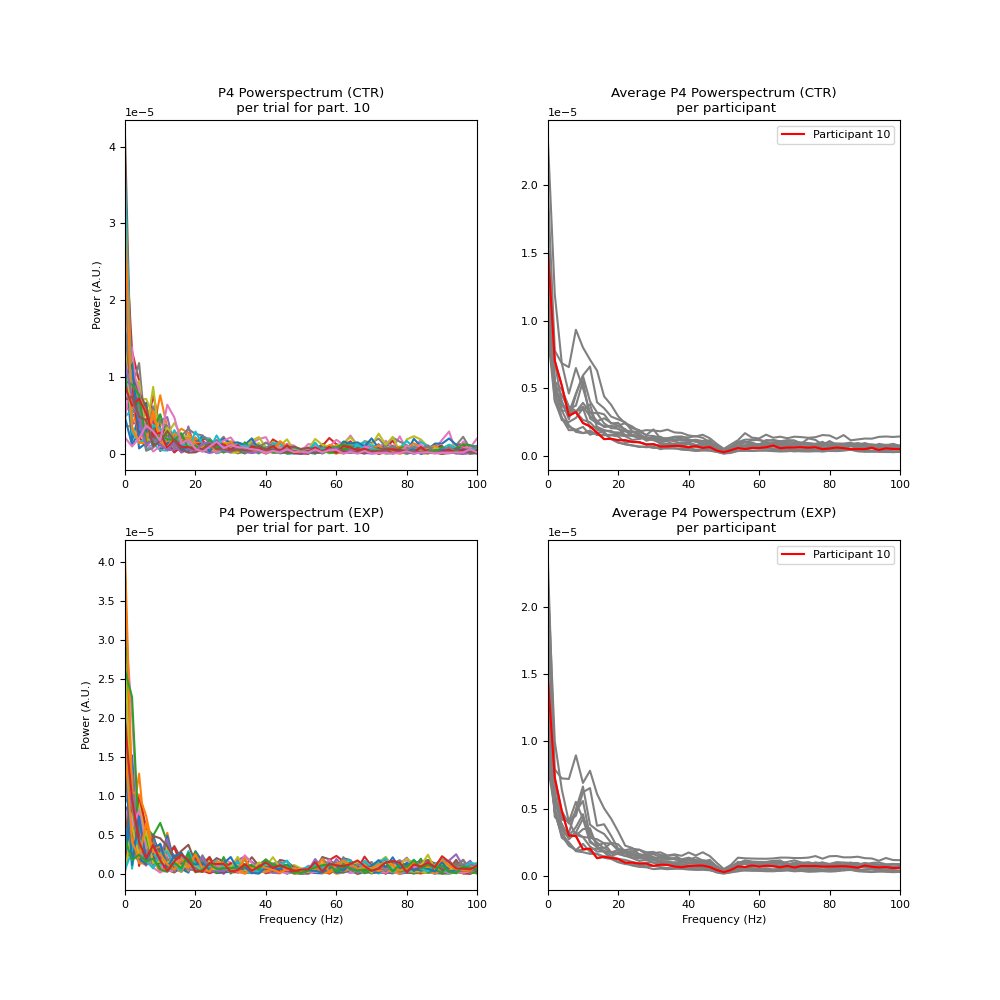

<ipython-input-29-f46f8ace20c8>:3: RuntimeWarning: Mean of empty slice
  chan_ps_ctr_av = np.nanmean(chan_ps_ctr, axis = 1) # first across trials
<ipython-input-29-f46f8ace20c8>:4: RuntimeWarning: Mean of empty slice
  chan_ps_exp_av = np.nanmean(chan_ps_exp, axis = 1) # first across trials


In [29]:
fig_Q8A, ax = plt.subplots(figsize=(10,10), nrows=2, ncols=2) # 1x2 graph

chan_ps_ctr_av = np.nanmean(chan_ps_ctr, axis = 1) # first across trials
chan_ps_exp_av = np.nanmean(chan_ps_exp, axis = 1) # first across trials

#print(av_per_part.shape)
ax[0,0].plot(spect_freqs,np.transpose(chan_ps_ctr_rand))
ax[0,0].set_xlim(0,100)
ax[0,0].set_ylabel("Power (A.U.)")
#ax[0,0].set_xlabel("Frequency (Hz)")
plt.axes(ax[0,0])
plt.title("P4 Powerspectrum (CTR)\n per trial for part. 10")

ax[1,0].plot(spect_freqs,np.transpose(chan_ps_exp_rand))
ax[1,0].set_xlim(0,100)
ax[1,0].set_ylabel("Power (A.U.)")
ax[1,0].set_xlabel("Frequency (Hz)")
plt.axes(ax[1,0])
plt.title("P4 Powerspectrum (EXP)\n per trial for part. 10")

ax[0,1].plot(spect_freqs,np.transpose(chan_ps_ctr_av), color = "grey")
ax[0,1].plot(spect_freqs,chan_ps_ctr_av[9,:], color = "red", label = "Participant 10")
ax[0,1].set_xlim(0,100)
plt.axes(ax[0,1])
plt.legend()
plt.title("Average P4 Powerspectrum (CTR)\n per participant")

ax[1,1].plot(spect_freqs,np.transpose(chan_ps_exp_av), color = "grey")
ax[1,1].plot(spect_freqs,chan_ps_exp_av[9,:], color = "red", label = "Participant 10")
ax[1,1].set_xlim(0,100)
ax[1,1].set_xlabel("Frequency (Hz)")
plt.axes(ax[1,1])
plt.legend()
plt.title("Average P4 Powerspectrum (EXP)\n per participant")




plt.show()


## Q9 - applying baseline normalization

To properly implement baseline normalization of the powerspectra, we use our calculated powerspectra over the baseline period as a normalization factor for each individual spectrum stored in our TFR-5D arrays. That means that all of those vectors of spectral power (1x nFreq) will get divided by a similar 1xnFreq vector of **baseline** power values, so that the result is a number. Values above 1 would indicate *more* power in the evoked period than the baseline period, and values below 1 indicate less power. 

In the right-hand plots in Q8 you have seen that there can be considerable between-person differences in spectral power. Doing the within person, within channel and within trial normalisation as outlined above takes care of these between person (or between channel) differences, because each trial (channel, participant) functions as its own **statistical control condition**. We will look into the statistics later. First, we need to normalise.

There are several ways to solve this problem. Fundamentally, we want to create new, normalised 5D TFR arrays, because the shape of the evoked period data does not change with normalisation, only its values.

- start by creating two arrays with the same shape as their corresponding non-normalised data
    - TFR_5D_ctr_norm
    - TFR_5D_exp_norm

Next, you apply some loop(s) to get at the data that needs to be normalised. The TFR_5D and TFR_xxx_base arrays differ on 1 dimension. 

- Start a loop that loops over that dimension.
- Inside that loop, you can subset the appropriate part of the TFR_5D arrays. Now there are two ways to proceed:
    - Either implement a direct matrix elementwise division. You would divide the appropriate 4D slice out of the TFR_5D by its corresponsing baseline array and store the result in the corresponding \_norm array
    - Or contruct further loops to dig down the other dimensions until you can extract the frequency power vector that corresponds to the current participant, trial, channel and window and divide that by its corresponding frequency vector from the corresponding baseline array. 
    
Now we should implement a check. Because the normalisation factor is the same for all windows out of the TFR_5D arrays, the *relative* differences should be maintained. 

- select a random participant, channel and trial number
- extract the *original* powerspectrum from the first and last window
- calculate the ratio in the spectrum between both window by element-wise division
- extratc the *normalised* powerspectrum from the same windows and perform element-wise division
- print both arrays to the console to show that they are equivalent
 


In [30]:
## set up empty arrays + NaN
TFR_5D_ctr_norm = np.zeros(TFR_5D_ctr.shape)+np.nan
TFR_5D_exp_norm = np.zeros(TFR_5D_exp.shape)+np.nan

## loop across windows

for iWindow in np.arange(nWindows):
    print("processing window: ", iWindow)
    print("shape to extract: ", TFR_5D_ctr[:,:,:,iWindow,:].shape)
    print("shape of baseline: ", TFR_ctr_base.shape)
    TFR_5D_ctr_norm[:,:,:,iWindow,:] = TFR_5D_ctr[:,:,:,iWindow,:]/TFR_ctr_base
    TFR_5D_exp_norm[:,:,:,iWindow,:] = TFR_5D_exp[:,:,:,iWindow,:]/TFR_exp_base
    
    
## show equivalence for a random part, trial, chan
ratio_orig = TFR_5D_ctr[5,1,2,0,:] / TFR_5D_ctr[5,1,2,-1,:]
ratio_norm = TFR_5D_ctr_norm[5,1,2,0,:] / TFR_5D_ctr_norm[5,1,2,-1,:]
pprint(np.reshape([ratio_orig,ratio_norm],(2,-1)).transpose())
    

processing window:  0
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)


<ipython-input-30-e5fa858164d3>:11: RuntimeWarning: divide by zero encountered in true_divide
  TFR_5D_ctr_norm[:,:,:,iWindow,:] = TFR_5D_ctr[:,:,:,iWindow,:]/TFR_ctr_base
<ipython-input-30-e5fa858164d3>:12: RuntimeWarning: divide by zero encountered in true_divide
  TFR_5D_exp_norm[:,:,:,iWindow,:] = TFR_5D_exp[:,:,:,iWindow,:]/TFR_exp_base


processing window:  1
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)
processing window:  2
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)


<ipython-input-30-e5fa858164d3>:12: RuntimeWarning: invalid value encountered in true_divide
  TFR_5D_exp_norm[:,:,:,iWindow,:] = TFR_5D_exp[:,:,:,iWindow,:]/TFR_exp_base


processing window:  3
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)
processing window:  4
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)
processing window:  5
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)
processing window:  6
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)
processing window:  7
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)
processing window:  8
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)
processing window:  9
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)
processing window:  10
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)
processing window:  11
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)
processing window:  12
shape to extract:  (15, 44, 59, 126)
shape of baseline:  (15, 44, 59, 126)
processing window:  13
shap

## Q10 Visualize the time-resolved, normalized TFR for a single channel

Now that both TFR_5D arrays have been normalized to TFR_5D_xxx_norm, we can once again plot from our channel of interest, P4. 

- From the normalised TFRs, extract the time-resolved powerspectrum for channel P4, for both the control and the experimental TFRs  
    - store as chan_TFR_norm_ctr and chan_TFR_norm_exp
    - verify that the shape is now nParts x nTrials x nWindows x nFreq

The values in these arrays represent normalised power values (ratios) for each time x frequency pair relative to their own baseline. As such, they can be larger than 1 (more power than in baseline) or smaller than 1 (less power than in baseline). To make that scale symmetric and linear, we can apply the log10 function to the averaged powerspectrum. 

- use np.log10 to convert the array of power ratios to a logarithmic scale
    - this can be applied to the entire array at once
    - store as chan_TFR_norm_ctr_log and chan_TFR_norm_exp_log
- select the data from only 1 participant (0 in the example) and take the average across the trial dimension
    - be careful of missing values (NaN) -> use np.nanmean
    - store as chan_TFR_norm_ctr_av, chan_TFR_norm_exp_av

To visualize this normalized P4-powerspectrum for a single participant, we first need the appropriate time axis, and next some index into the normalised TFR arrays. Let's take the first participant as an example. Construct the time axis as a vector that has the starting points of the windows in the evoked period in seconds, not samples. 

- Extract the window start samples corresponding to the evoked period as vector of nWindow samples. 
- Index into the time array to find the starting points of theses windows in seconds
    - check: the first evoked windows starts at -0.5s.
    - store this vector as time_evoked_plot

Now you can extract the normalized powerspectrum for the first participant (this should be an nWindow x nFreq array), and plot against time_evoked_plot. You can use the function **pcolormesh** from matplotlib for this. The first argument to this function is the time (x-axis), the second the frequencies (y-axis) and the third is the TFR (z-axis: color scale). 

- Plot the normalised TFRs for the evoked period
    - plot in a 1x2 subplot with the control data (left) and experimental data (right)
    - restrict the frequency range (y-axis) to max 100 Hz
    - Apply appropriate annotation and formatting
    - Store as fig_Q10A
    - Evaluate the colormap and colorbar functions as indicated.
    - adjust vmin and vmax to the power in the frequencies above 0  - the DC offset can vary quite a bit
        - ensure that they are symmetric around zero - the green colors will indicate 0 (i.e. no change)

Depending on your particular task conditions, you might see some postive (i.e. larger than baseline) activity in the Beta or low Gamma Bands (around 30Hz).

In [31]:
# extract channel of interest
chan_idx = ch_names.index("P4")
chan_TFR_norm_ctr = TFR_5D_ctr_norm[:,:,chan_idx,:,:]
chan_TFR_norm_exp = TFR_5D_exp_norm[:,:,chan_idx,:,:]
print("the shape of chan_TFR_norm_ctr is: ", chan_TFR_norm_ctr.shape)

# log10 normalisation
chan_TFR_norm_ctr_log = np.log10(chan_TFR_norm_ctr)
chan_TFR_norm_exp_log = np.log10(chan_TFR_norm_exp)

# select first participant, average across trials
chan_TFR_norm_ctr_av = np.nanmean(chan_TFR_norm_ctr_log[0,:,:,:], axis = 0)
chan_TFR_norm_exp_av = np.nanmean(chan_TFR_norm_exp_log[0,:,:,:], axis = 0)

## check the shape: what are the dimension that we have left?
print("the shape of chan_TFR_norm_ctr_av is: ",chan_TFR_norm_ctr_av.shape)
print("the shape of chan_TFR_norm_exp_av is: ",chan_TFR_norm_exp_av.shape)

the shape of chan_TFR_norm_ctr is:  (15, 44, 21, 126)
the shape of chan_TFR_norm_ctr_av is:  (21, 126)
the shape of chan_TFR_norm_exp_av is:  (21, 126)


<ipython-input-31-a4e559e8a597>:8: RuntimeWarning: divide by zero encountered in log10
  chan_TFR_norm_ctr_log = np.log10(chan_TFR_norm_ctr)
<ipython-input-31-a4e559e8a597>:9: RuntimeWarning: divide by zero encountered in log10
  chan_TFR_norm_exp_log = np.log10(chan_TFR_norm_exp)


In [32]:
chan_TFR_norm_ctr_av.shape

(21, 126)

check: the first timepoint for the plots is:  -0.5


<IPython.core.display.Javascript object>


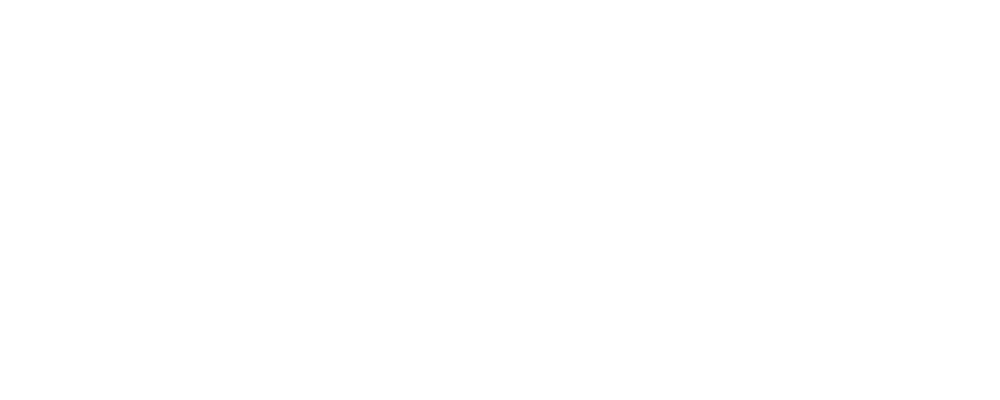

In [33]:
# set up time_evoked_plot: what are the time indexes in second for the windows?
time_evoked_plot = time_evoked[window_starts]

# verify the starting time of the evoked TFR
print("check: the first timepoint for the plots is: ", time_evoked_plot[0])

## set up the plot
fig_Q10, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2) # 1x2 graph

# you may need to use np.transpose
ctrl = ax[0].pcolormesh(time_evoked_plot, spect_freqs, np.transpose(chan_TFR_norm_ctr_av), vmin=-0.5, vmax=0.5, cmap='jet')
exp = ax[1].pcolormesh(time_evoked_plot, spect_freqs, np.transpose(chan_TFR_norm_exp_av), vmin=-0.5, vmax=0.5, cmap='jet')


ax[0].set_ylim(0,100)
ax[1].set_ylim(0,100)
ax[0].set_xlabel('time')
ax[1].set_xlabel('time')
ax[0].set_ylabel('frequency')
ax[1].set_ylabel('frequency')
plt.axes(ax[0])
plt.title("normalized TFR, P4 channel, participant 1\n CONTROL")
plt.axes(ax[1])
plt.title("normalized TFR, P4 channel, participant 1\n EXPERIMENTAL")

fig_Q10.colorbar(ctrl, ax=ax[0])
fig_Q10.colorbar(exp, ax=ax[1])
plt.show()

## Q11 Averaged Power Spectrum Contrast across participants.

Now that we have created a normalized TFR for both the control and experimental conditions, we can start to combine these two conditions to work towards the final statistical contrast we want to showcase.

We will zoom in to the contrast between control and experimental conditions in this exercise. Because the normalized TFR arrays are now in the same scale between conditions and between participants (in power *differences*), they can be subtracted and averaged easily. You will create **contrast plots** that shows the power difference between conditions, and average these powerspectrum contrasts across participants, to look for consistent frequency responses between individuals.  Based on the qualitatively interesting parts of this contrast, you will extract the power constrast in a certain spectral band (delta, theta, alpha, beta, gamma as assigned to your group and visualise the spectral band values.

- Start by making a 4D power trial-avaraged contrast array from the normalised TFRs
    - subtract the control condition from the experimental condition (so that larger values in the exp. condition show up as positive
    - average across the trial dimension
    - store as TFR_contrast_norm
- Then, for visualiation, create an average contrast TFR (averaged across participants)
    - (keep the 4D array around, because we need the individual data for statistics)
    - store as TFR_contrast_av
- Finally, create a loop across channels that plots a graph for each channel showing these averaged TFR contrasts across participants

Explore these contrast plots for each channel. Can you find a channel with an interesting "rectangle" in the TFR where an increase or decrease in power in your frequency band might occur? If not, then just select the time window from 0 (included) to 200ms after the onset of the critical item

- Start a plot with two subplots
    - Plot the averaged contrast TFR for your channel of interest into the first subplot of Fig_Q11
- Define a window in the averaged power contrast as a time-by-frequency cutout window:
    - see the setup notebook for the frequency cutoffs. Include both the lower and upper limit of your assigned frequency band!
    - select a time window of interest as defined in ms
- Create indexes into the TFR arrays that correspond to your window limits
    - define foi (frequency of interest) as a 2-element vector with your lower and upper frequencies (in Hz)
    - define toi (time of interest) as a 2-element vector with the start and end of your window of interest (in s)
    - define foi_index as the element numbers of the corresponding entries in your frequency axis (from Q10)
        - example: if your upper limit is 100Hz, which element in the frequency axis is this
        - if the frequency resolution would be 1Hz, this would be element 100 (0 being 0 Hz, 1 being 1 etc.)
        - so you need to adjust the index to your frequency resolution
        - if there is no precise fit, choose the index closest to the border without crossing your rectangle
    - define toi_index similarly as the element numbers (index) in the time axis (which was derived from window_starts)
- Extract the power values from the TFR_contrast_norm array with these indexes:
    - apply the foi_index slice to the frequency dimension
    - apply the toi_index slice to the window dimension
    - apply your channel selection to extract just that channel
    - the result should be nParticipants * nWindows * nFreq
    - average across the windows and frequencies dimensions
- You now have just a single 1D vector left of power values that are averaged across trials and your rectangle of interest, for only a single channel. 
    - plot a histogram, boxplot or violin plot showing the distribution of these values in the second subplot
    - add proper annotation and labelling to both subplots
- Save this Figure as your Figure3 for your report
    
### optional

You can assess the significance of this contrast distribution by comparing it to a population mean of zero. Use Scipy.Stats to apply the appropriate one-sample test for this hypothesis as shown in the example

In [34]:
# calculate the contrast TFR
TFR_contrast_norm = np.nanmean(TFR_5D_exp_norm - TFR_5D_ctr_norm, axis = 1)

#calculate the average across participants
TFR_contrast_av = np.nanmean(TFR_contrast_norm, axis = 0)

print("The shape of TFR_contrast_av is: ", TFR_contrast_av.shape)


The shape of TFR_contrast_av is:  (59, 21, 126)


/Users/udeshhabaraduwa/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-34-901b261e2b75>:2: RuntimeWarning: Mean of empty slice
  TFR_contrast_norm = np.nanmean(TFR_5D_exp_norm - TFR_5D_ctr_norm, axis = 1)


<IPython.core.display.Javascript object>


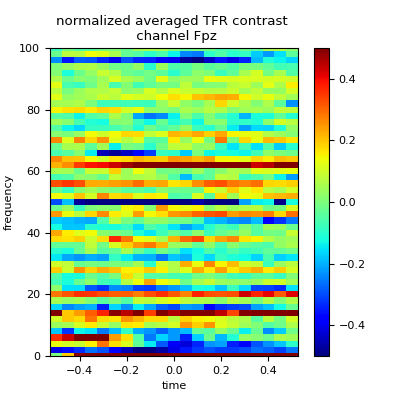

<IPython.core.display.Javascript object>


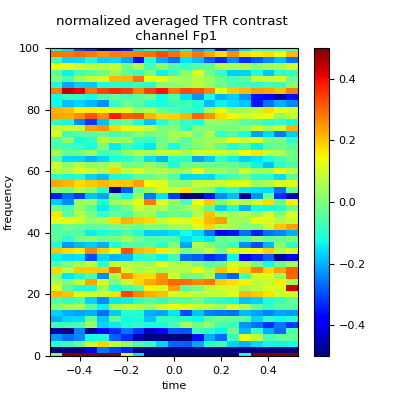

<IPython.core.display.Javascript object>


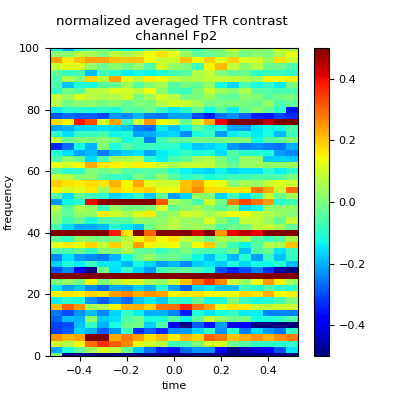

<IPython.core.display.Javascript object>


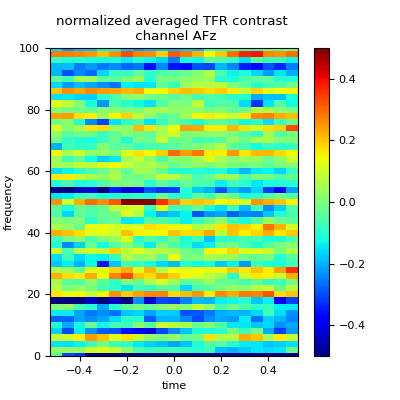

<IPython.core.display.Javascript object>


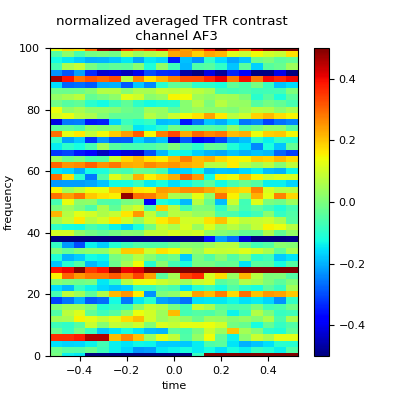

<IPython.core.display.Javascript object>


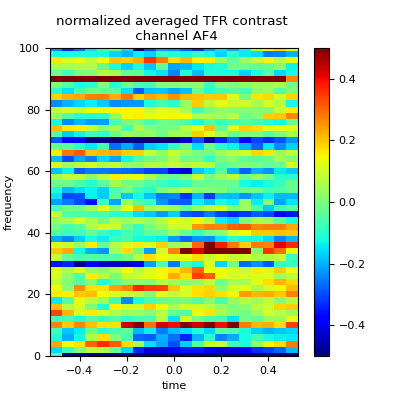

<IPython.core.display.Javascript object>


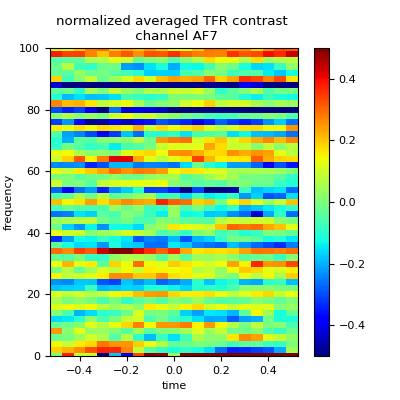

<IPython.core.display.Javascript object>


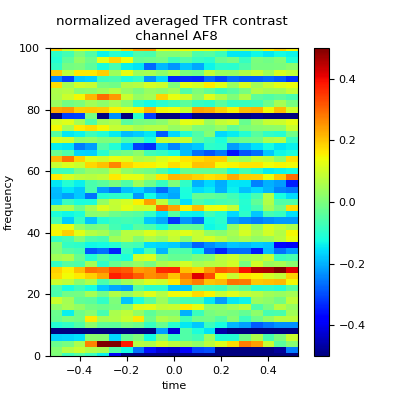

<IPython.core.display.Javascript object>


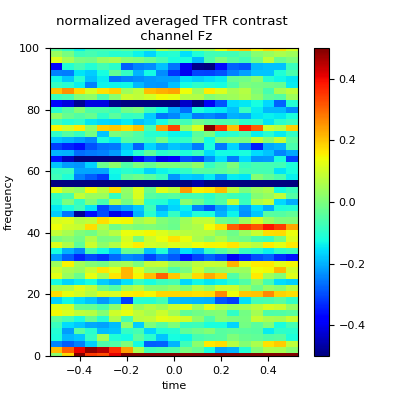

<IPython.core.display.Javascript object>


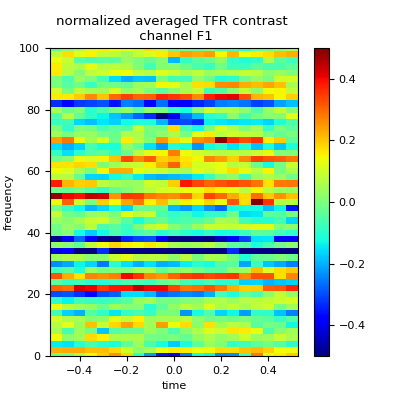

<IPython.core.display.Javascript object>


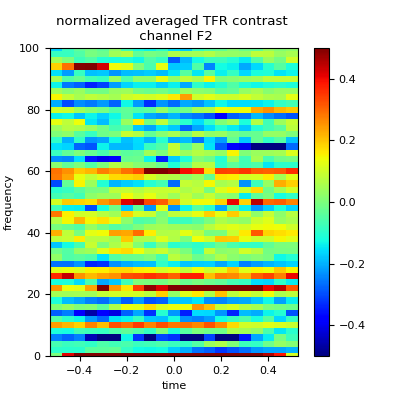

<IPython.core.display.Javascript object>


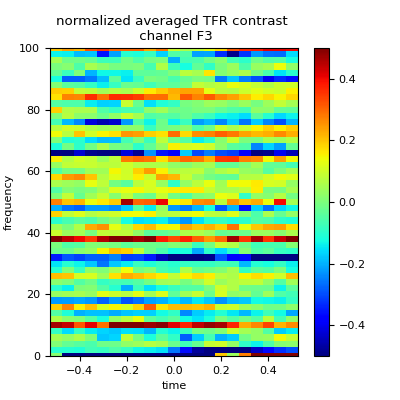

<IPython.core.display.Javascript object>


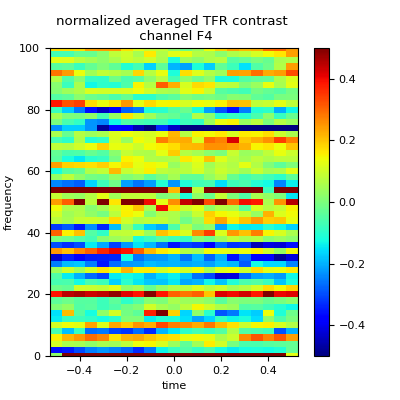

<IPython.core.display.Javascript object>


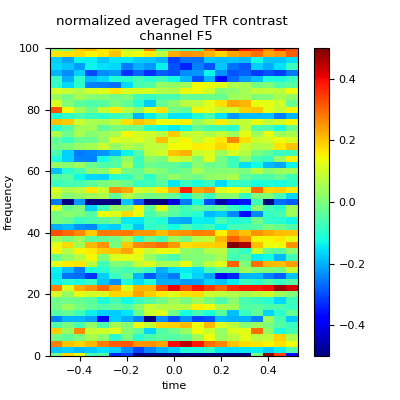

<IPython.core.display.Javascript object>


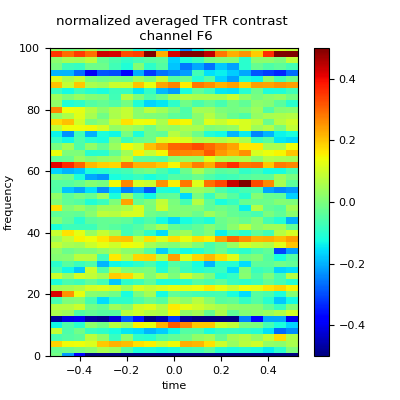

<IPython.core.display.Javascript object>


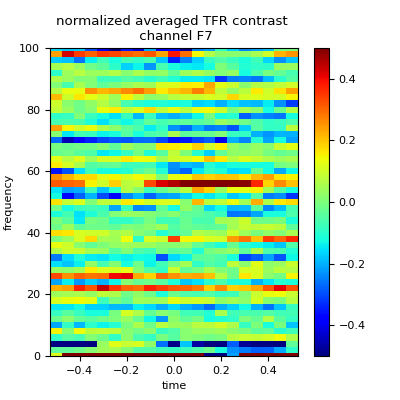

<ipython-input-103-2bc842254a9d>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4,4), nrows=1, ncols=1) # 1x1 graph


<IPython.core.display.Javascript object>


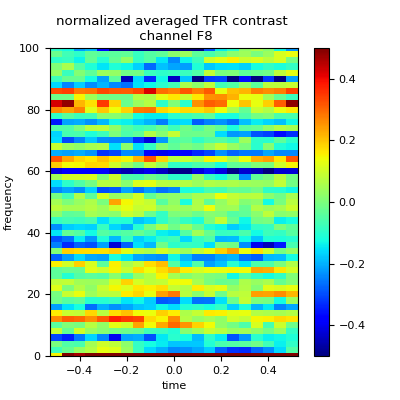

<IPython.core.display.Javascript object>


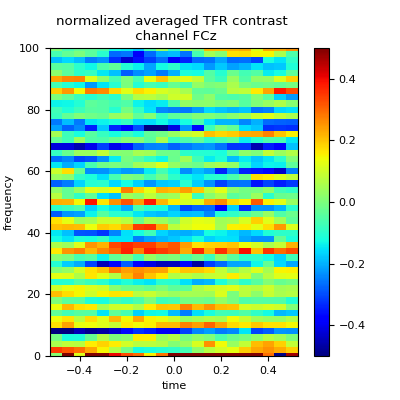

<IPython.core.display.Javascript object>


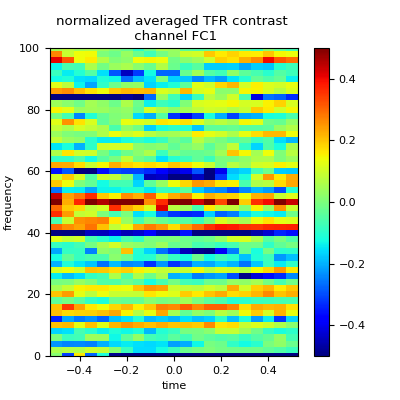

<IPython.core.display.Javascript object>


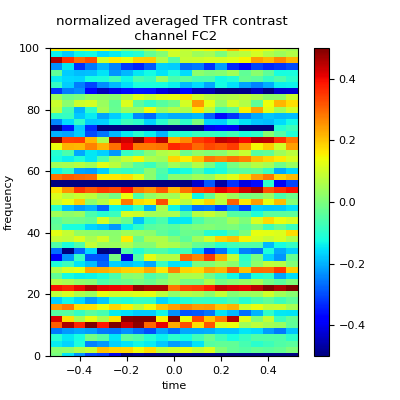

<IPython.core.display.Javascript object>


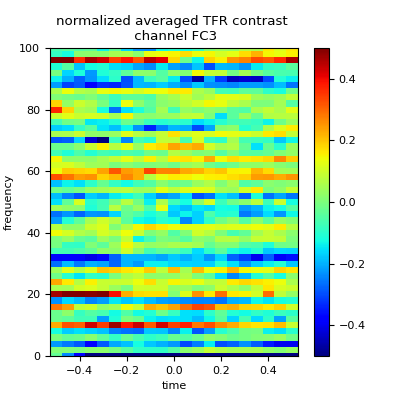

<IPython.core.display.Javascript object>


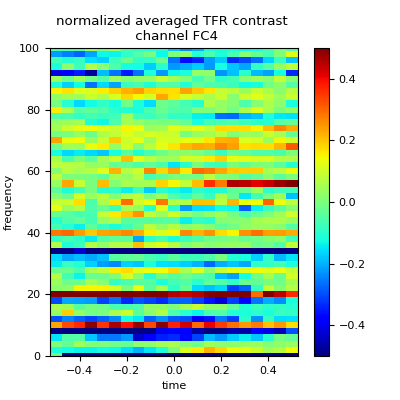

<IPython.core.display.Javascript object>


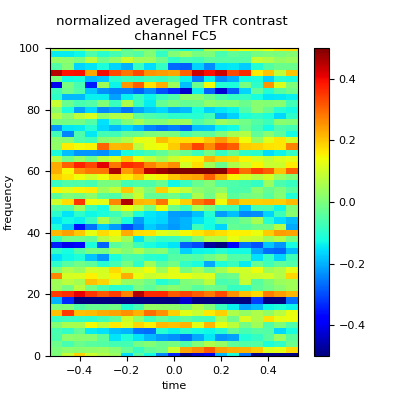

<IPython.core.display.Javascript object>


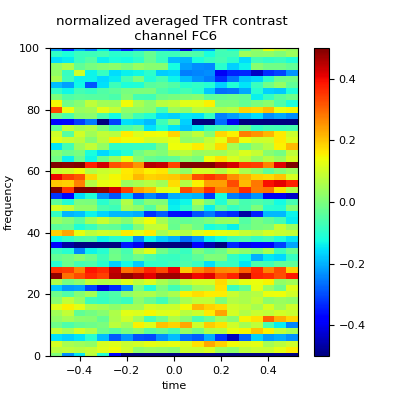

<IPython.core.display.Javascript object>


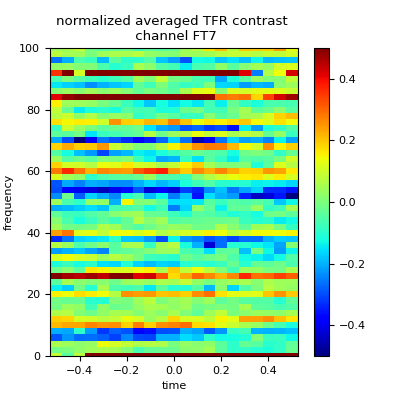

<IPython.core.display.Javascript object>


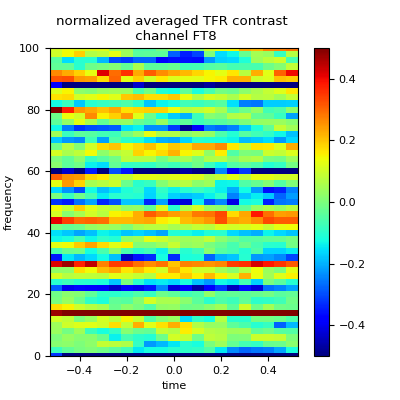

<IPython.core.display.Javascript object>


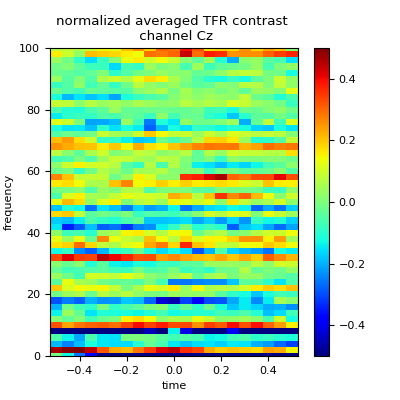

<IPython.core.display.Javascript object>


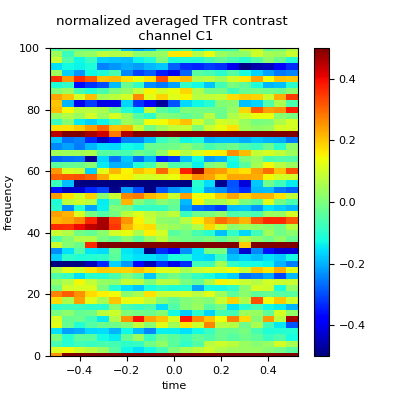

<IPython.core.display.Javascript object>


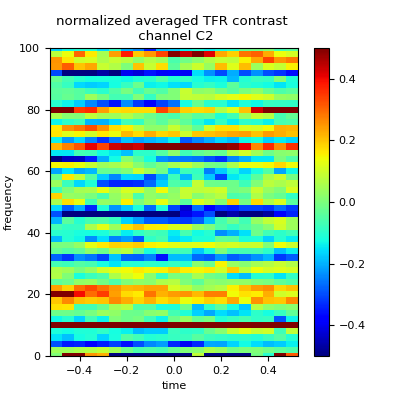

<IPython.core.display.Javascript object>


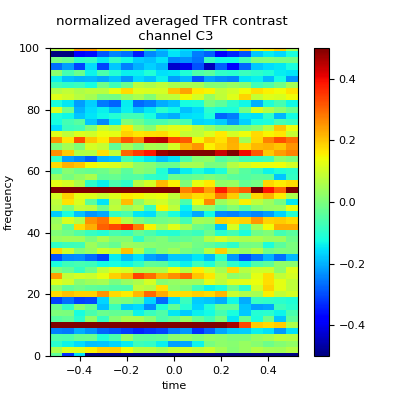

<IPython.core.display.Javascript object>


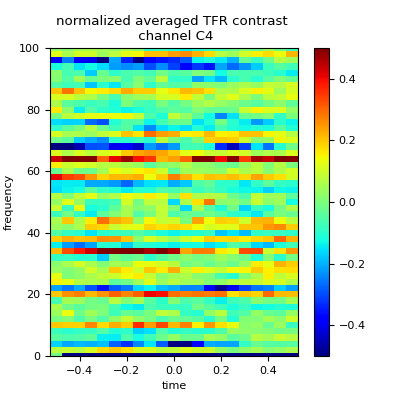

<IPython.core.display.Javascript object>


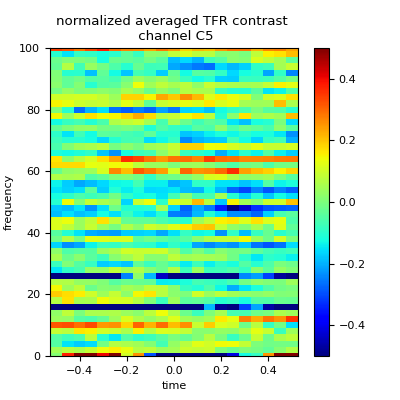

<IPython.core.display.Javascript object>


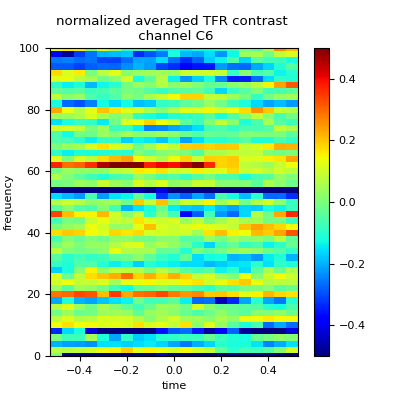

<IPython.core.display.Javascript object>


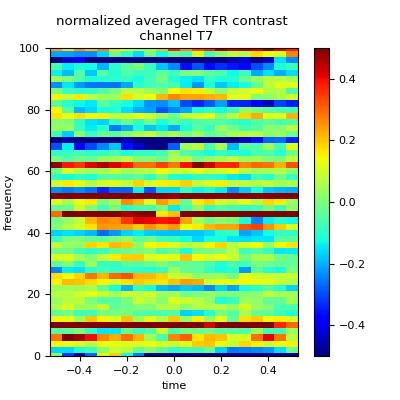

<IPython.core.display.Javascript object>


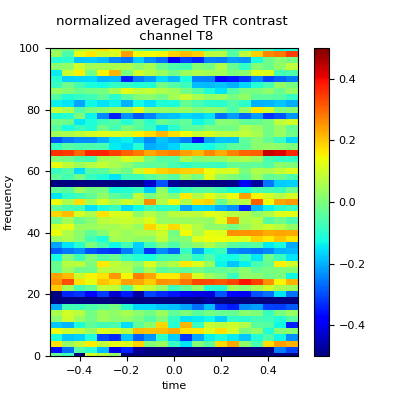

<IPython.core.display.Javascript object>


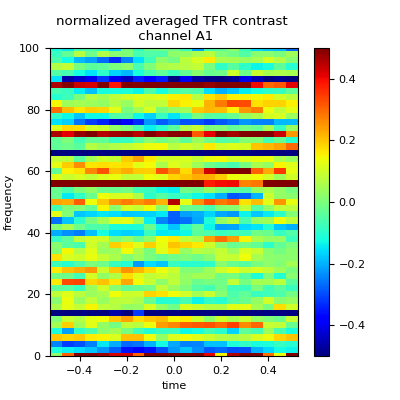

<IPython.core.display.Javascript object>


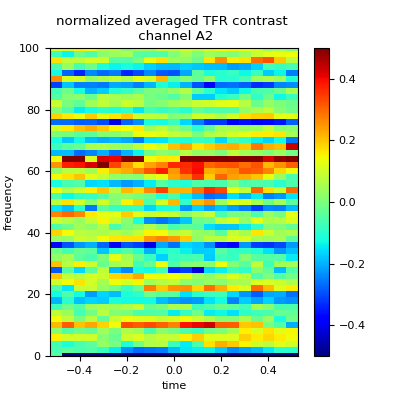

<IPython.core.display.Javascript object>


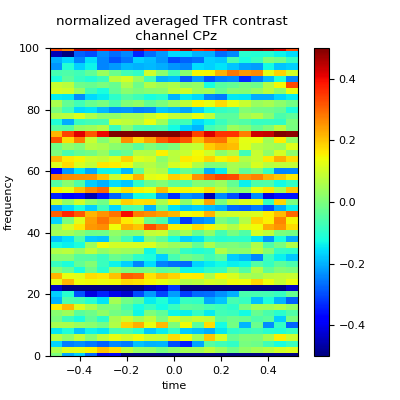

<IPython.core.display.Javascript object>


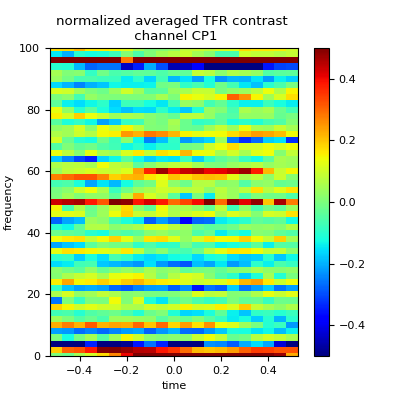

<IPython.core.display.Javascript object>


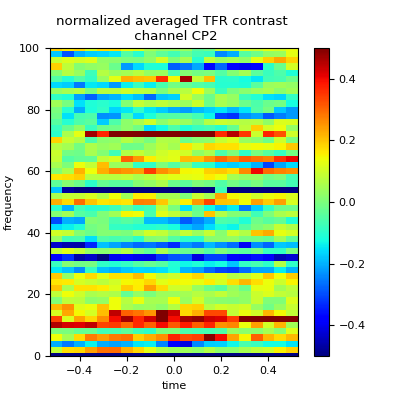

<IPython.core.display.Javascript object>


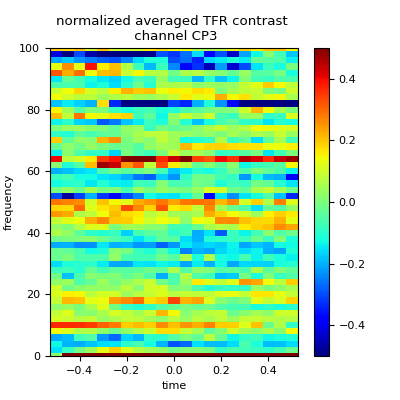

<IPython.core.display.Javascript object>


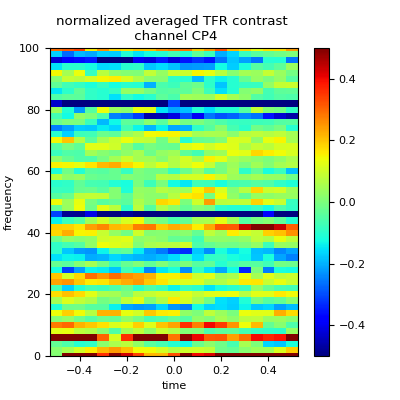

<IPython.core.display.Javascript object>


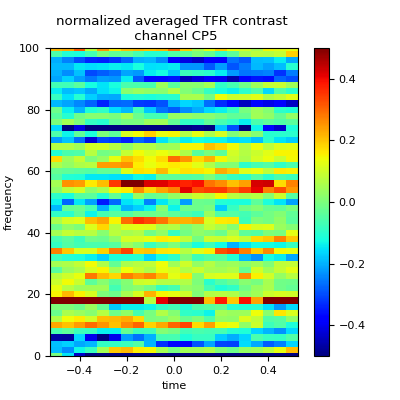

<IPython.core.display.Javascript object>


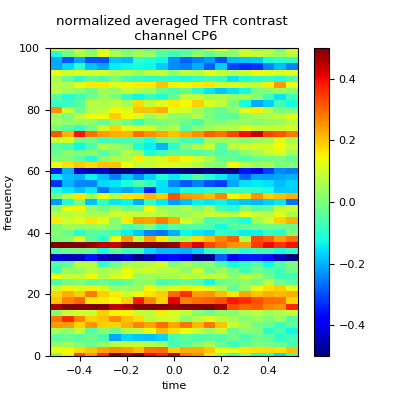

<IPython.core.display.Javascript object>


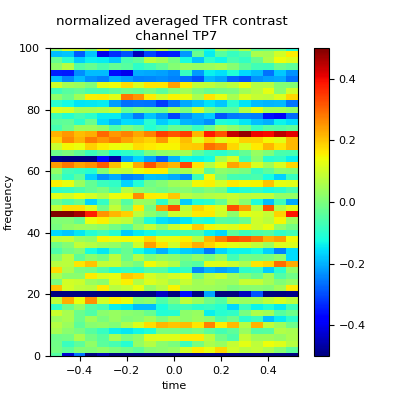

<IPython.core.display.Javascript object>


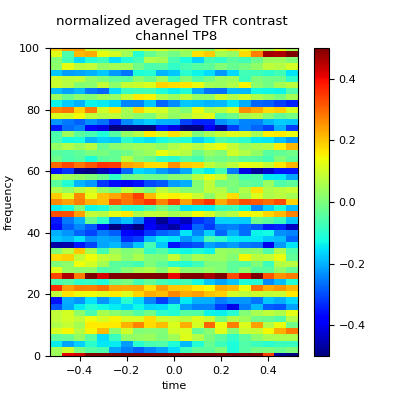

<IPython.core.display.Javascript object>


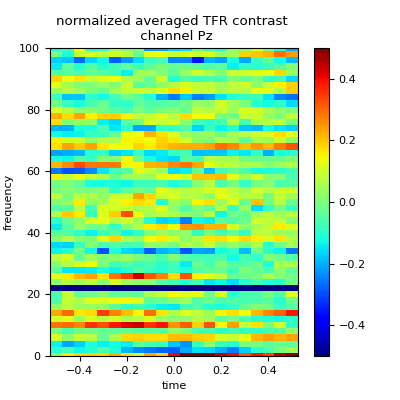

<IPython.core.display.Javascript object>


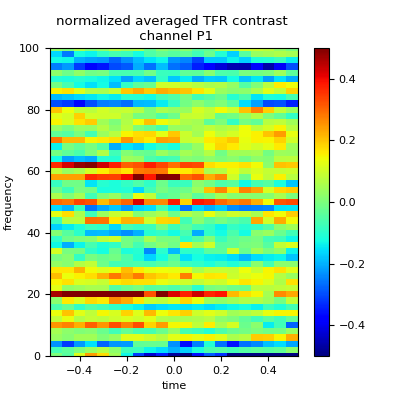

<IPython.core.display.Javascript object>


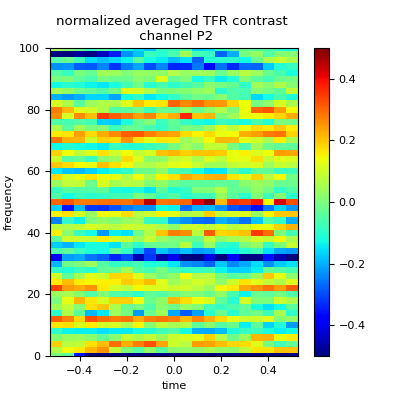

<IPython.core.display.Javascript object>


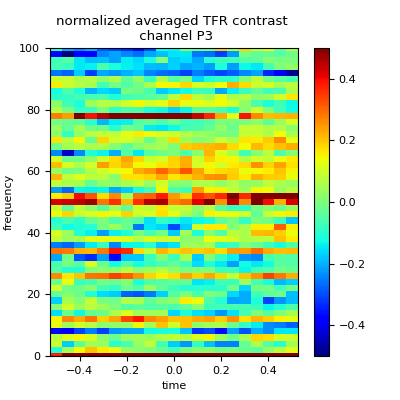

<IPython.core.display.Javascript object>


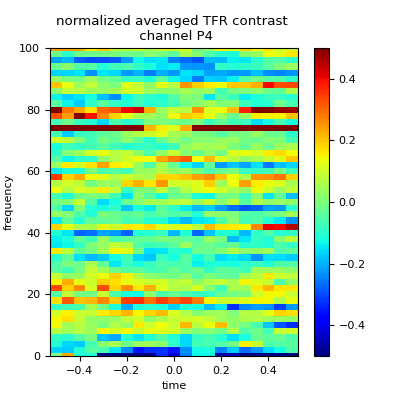

<IPython.core.display.Javascript object>


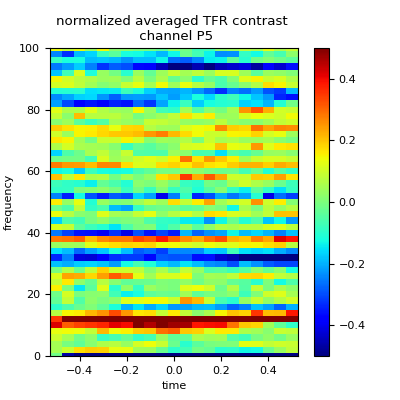

<IPython.core.display.Javascript object>


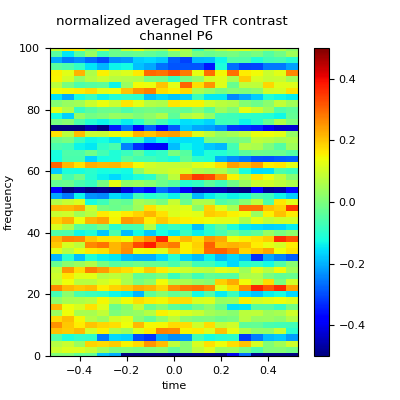

<IPython.core.display.Javascript object>


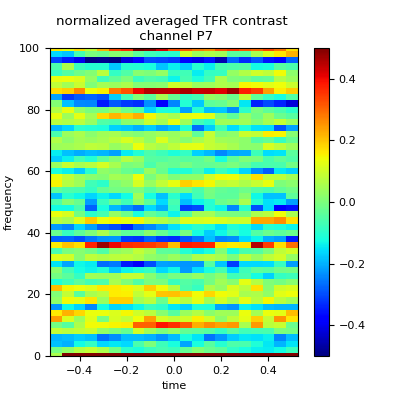

<IPython.core.display.Javascript object>


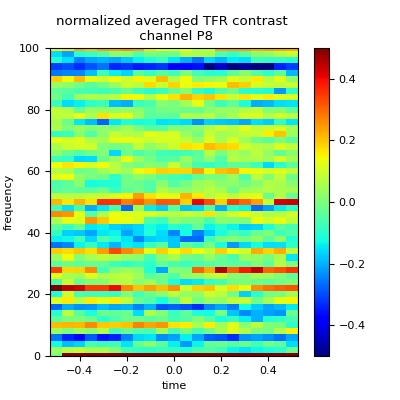

<IPython.core.display.Javascript object>


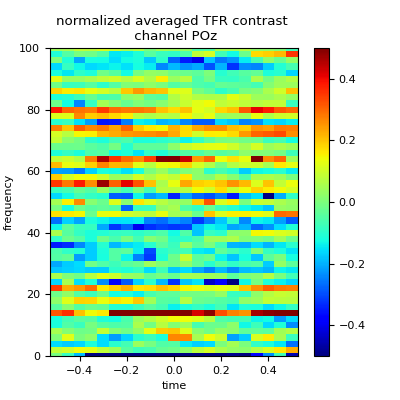

<IPython.core.display.Javascript object>


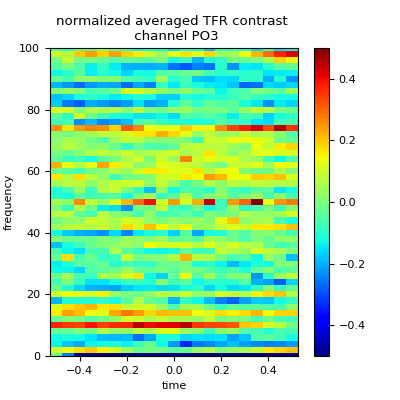

<IPython.core.display.Javascript object>


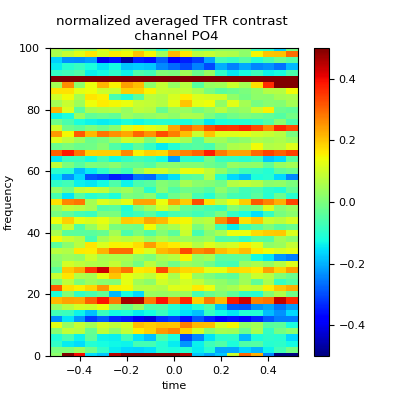

<IPython.core.display.Javascript object>


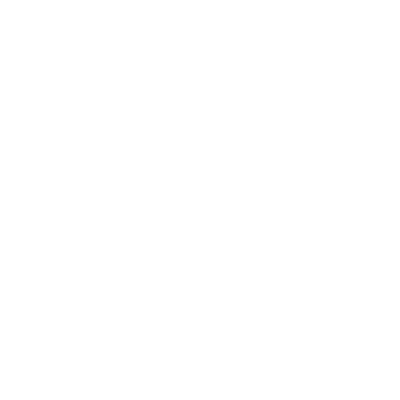

In [103]:
# start a loop across participants
# plot the average contrast per channel in a new figure
# adjust vmin and vmax to reasonable values for visualisation
for i in range(len(ch_names)):
    fig, ax = plt.subplots(figsize=(4,4), nrows=1, ncols=1) # 1x1 graph
    curr_data = np.nanmean(TFR_contrast_norm[:,i,:,:], axis = 0)
    vmin = -0.5
    vmax = 0.5
    mesh = ax.pcolormesh(time_evoked_plot, spect_freqs, curr_data.T, vmin=vmin, vmax=vmax, cmap='jet')
    ax.set_ylim(0,100)
    ax.set_xlabel('time')
    ax.set_ylabel('frequency')
    plt.title('normalized averaged TFR contrast \n channel {}'.format(ch_names[i]))
    
    fig.colorbar(mesh, ax=ax)


the size of selected_contrast_subset_av is:  (15,)
[-2.52124265e-01  2.03122454e-01 -4.72861477e-01  3.42117751e-01
 -6.59371610e-01 -2.76760618e-04  2.40109591e-01 -3.37866905e+00
  4.51943419e-01  1.37965659e-01  4.41549628e-01             nan
  6.95155992e-01  4.13640005e-02 -5.81137217e-01]


<ipython-input-39-9f0fc9c49448>:20: RuntimeWarning: Mean of empty slice
  selected_contrast_subset_av = np.nanmean(np.nanmean(selected_contrast_subset, axis = 1),axis = 1)


<IPython.core.display.Javascript object>


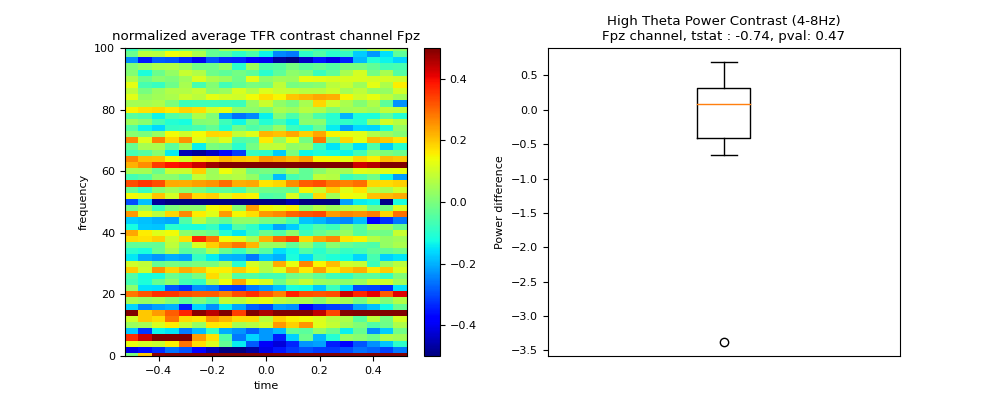

In [39]:
# just the selected channel
vmin = -0.5
vmax = 0.5
chan_name = "Fpz"
chan_idx = ch_names.index("Fpz")
selected_contrast = TFR_contrast_norm[:,chan_idx,:,:]
selected_contrast_av = TFR_contrast_av[chan_idx,:,:]

# define foi and toi in Hz and sec
foi = [4,8]
toi = [0,0.2]

# define as indexes
foi_index = np.arange(np.where(spect_freqs==4)[0][0], np.where(spect_freqs==8)[0][0] + 1)
toi_index = np.arange(np.where(np.round(time_evoked_plot,2) == 0)[0][0],np.where(np.round(time_evoked_plot,2) == 0.2)[0][0] + 1)
# subset the selected_contrast on foi and toi
selected_contrast_subset = selected_contrast[:,toi_index,foi_index[:,np.newaxis]]

# take the average across windows and frequencies
selected_contrast_subset_av = np.nanmean(np.nanmean(selected_contrast_subset, axis = 1),axis = 1)
print("the size of selected_contrast_subset_av is: ", selected_contrast_subset_av.shape)
print(selected_contrast_subset_av)

plt.clf()
fig_Q11, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2) # 1x2 graph
mesh = ax[0].pcolormesh(time_evoked_plot, spect_freqs, selected_contrast_av.T, vmin=vmin, vmax=vmax, cmap='jet')

# set to match your plotted data range
vmin = np.min(selected_contrast_av)
vmax = np.max(selected_contrast_av)

ax[0].set_ylim(0,100)
ax[0].set_xlabel('time')
ax[0].set_ylabel('frequency')
plt.axes(ax[0])
plt.title('normalized average TFR contrast channel {}'.format(chan_name))

fig_Q11.colorbar(mesh, ax=ax[0])

# to remove any NaNs that might still be in the vector
stats_vector = selected_contrast_subset_av[np.logical_not(np.isnan(selected_contrast_subset_av))]
#print(stats_vector)

#optional
import scipy.stats as stats
tstat, pval = stats.ttest_1samp(stats_vector,popmean = 0)

#required
ax[1].boxplot(stats_vector)
ax[1].set_xticks([])
plt.axes(ax[1])
ax[1].set_ylabel('Power difference')
plt.title('High Theta Power Contrast (4-8Hz)\n{} channel, tstat : {}, pval: {}'.format(chan_name, np.round(tstat, 2), np.round(pval,2)))

plt.savefig('example_contrast.png', format = 'png')
plt.show()



## Q12 - open figure creation with frequency band subsetting & confidence interval

For this last exercise, you should combine the different steps taken before to create a new plot or series of plots. You are free to explore different channels, create TFRs and contrast TFRs to find an interesting combination in your frequency band. Your final plot should show:
- the timecourse of normalised power for the control and experimental condition
    - for a given spectral power band (e.g. averaged across all theta frequencies)
OR
- the timecourse of the experimental-control contrast
    - for a given spectral power band

In both cases, plot:
- the mean across participants as a colored line
- the upper and lower confidence interval on these values (that is, from the population of participants)
    - Choose +1 std and -1 std as the confidence interval
    - use np.fill_between to make plot the CI shading around the mean
    
This should result in a timeseries plot of the mean spectral power with its confidence interval, tracking the evolution of average spectral power in a given band over the evoked period of the trial. Add appropriate annotation and labeling and save fig_Q12 as Figure4 for you report.

The image below is just an example, feel free to go fancy!


(15, 21, 3)
the size of selected_contrast_subset_av is:  (21,)
(21,)


<IPython.core.display.Javascript object>


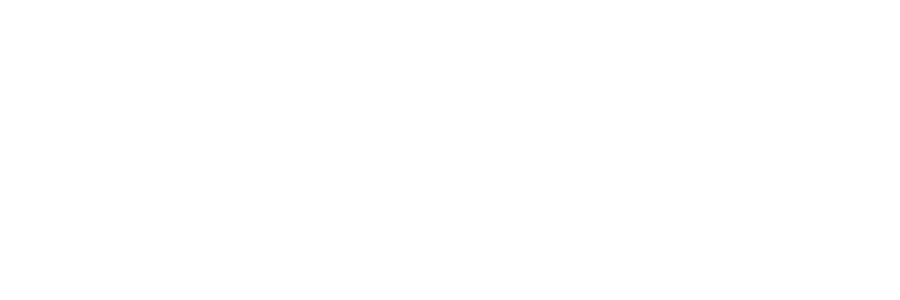

In [40]:
##
## your code here
##
selected_contrast_subset = selected_contrast[:,:,foi_index]
# take the average across windows and frequencies
print(selected_contrast_subset.shape)
selected_contrast_subset_av = np.nanmean(np.nanmean(selected_contrast_subset, axis = 0), axis = 1)
print("the size of selected_contrast_subset_av is: ", selected_contrast_subset_av.shape)
print(selected_contrast_subset_av.shape)
fig1 , ax1 = plt.subplots(figsize=(9, 3))
ax1.axhline(y=0, color='b', linestyle='-', label = 'no difference')
ax1.plot(time_evoked_plot, selected_contrast_subset_av, color = 'r', label = 'mean power contrast')
#ax1.ylim(2,-4)
ax1.set_ylim([-1, 1])
ax1.set_xlim([-0.5,0.5])
ax1.fill_between(time_evoked_plot, selected_contrast_subset_av + np.std(np.nanmean(selected_contrast_subset, axis = 0)),
                 selected_contrast_subset_av - np.std(np.nanmean(selected_contrast_subset, axis = 0)),
                 alpha = 0.4, 
                 color = 'r')
ax1.set_title('Time Course of Normalized High Theta TFR Power Contrast \n channel {}'.format(chan_name))
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Normalized power contrast')
fig1.tight_layout()
plt.savefig('TFR_timecourse.png', format = 'png')
plt.show()

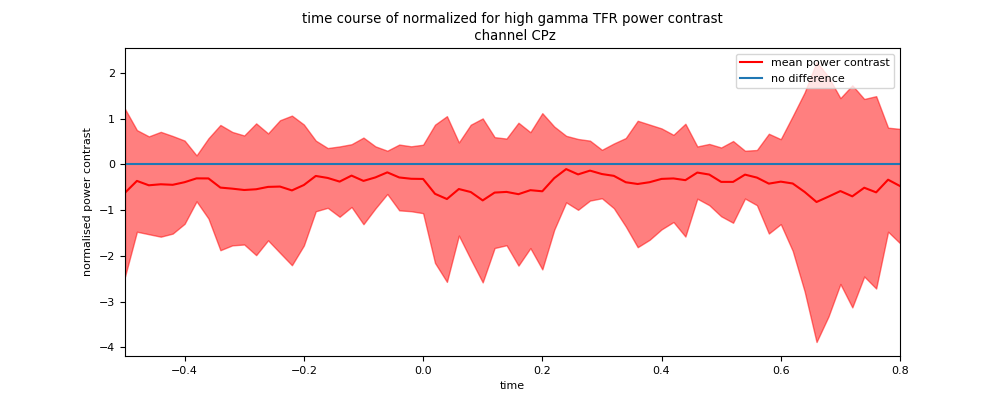

## Analysis of Regions of interest

In [65]:
left_anterior = ['F1','F3','F5','FC1','FC3','FC5']
right_anterior = ['F2', 'F4', 'F6', 'FC2', 'FC4', 'FC6']
left_posterior = ['CP1', 'CP3', 'CP5', 'P1', 'P3', 'P5']
right_posterior = ['CP2', 'CP4', 'CP6', 'P2', 'P4', 'P6']
left_anterior_index = []
right_anterior_index = []
left_posterior_index = []
right_posterior_index = []
for chan in left_anterior:
    left_anterior_index.append(ch_names.index(chan))
for chan in right_anterior:
    right_anterior_index.append(ch_names.index(chan))
for chan in left_posterior:
    left_posterior_index.append(ch_names.index(chan))
for chan in right_posterior:
    right_posterior_index.append(ch_names.index(chan))

the size of selected_contrast_subset_av is:  (15,)
[ 1.20207837  0.22930633 -0.0438392  -0.08305018 -0.08997776  0.16828972
  0.31447855 -0.07372276  0.13727655  0.09090782 -0.23601157         nan
 -0.43966243 -0.42628516 -0.35499845]


/Users/udeshhabaraduwa/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-78-0d1c384f2ce0>:6: RuntimeWarning: Mean of empty slice
  selected_contrast = np.nanmean(TFR_contrast_norm[:,right_posterior_index,:,:],axis = 1)
<ipython-input-78-0d1c384f2ce0>:20: RuntimeWarning: Mean of empty slice
  selected_contrast_subset_av = np.nanmean(np.nanmean(selected_contrast_subset, axis = 1),axis = 1)


<IPython.core.display.Javascript object>


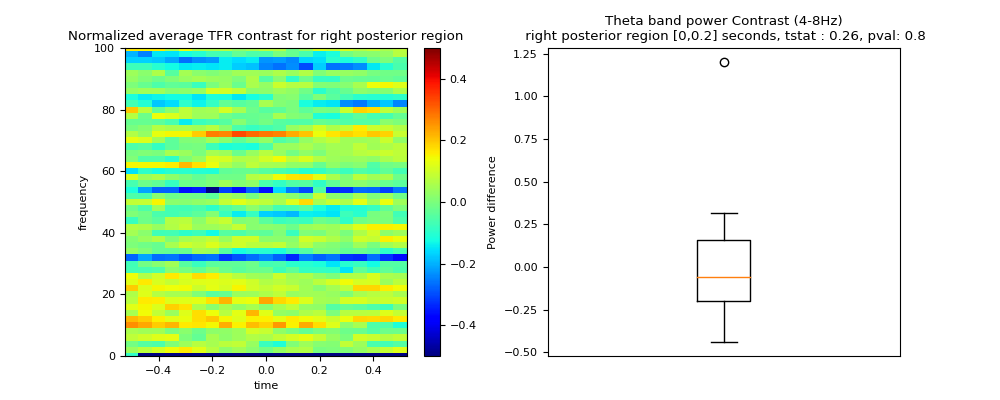

In [78]:
# just the selected channel
vmin = -0.5
vmax = 0.5
chan_name = "F1"
chan_idx = ch_names.index("F1")
selected_contrast = np.nanmean(TFR_contrast_norm[:,right_posterior_index,:,:],axis = 1)
selected_contrast_av = np.nanmean(TFR_contrast_av[right_posterior_index,:,:], axis = 0)

# define foi and toi in Hz and sec
foi = [4,8]
toi = [0,0.2]

# define as indexes
foi_index = np.arange(np.where(spect_freqs==4)[0][0], np.where(spect_freqs==8)[0][0] + 1)
toi_index = np.arange(np.where(np.round(time_evoked_plot,2) == 0)[0][0],np.where(np.round(time_evoked_plot,2) == 0.2)[0][0] + 1)
# subset the selected_contrast on foi and toi
selected_contrast_subset = selected_contrast[:,toi_index,foi_index[:,np.newaxis]]

# take the average across windows and frequencies
selected_contrast_subset_av = np.nanmean(np.nanmean(selected_contrast_subset, axis = 1),axis = 1)
print("the size of selected_contrast_subset_av is: ", selected_contrast_subset_av.shape)
print(selected_contrast_subset_av)

plt.clf()
fig_Q11, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2) # 1x2 graph
mesh = ax[0].pcolormesh(time_evoked_plot, spect_freqs, selected_contrast_av.T, vmin=vmin, vmax=vmax, cmap='jet')

# set to match your plotted data range
vmin = np.min(selected_contrast_av)
vmax = np.max(selected_contrast_av)

ax[0].set_ylim(0,100)
ax[0].set_xlabel('time')
ax[0].set_ylabel('frequency')
plt.axes(ax[0])
plt.title('Normalized average TFR contrast for right posterior region')

fig_Q11.colorbar(mesh, ax=ax[0])

# to remove any NaNs that might still be in the vector
stats_vector = selected_contrast_subset_av[np.logical_not(np.isnan(selected_contrast_subset_av))]
#print(stats_vector)

#optional
import scipy.stats as stats
tstat, pval = stats.ttest_1samp(stats_vector,popmean = 0)

#required
ax[1].boxplot(stats_vector)
ax[1].set_xticks([])
plt.axes(ax[1])
ax[1].set_ylabel('Power difference')
plt.title('Theta band power Contrast (4-8Hz)\n right posterior region [0,0.2] seconds, tstat : {}, pval: {}'.format(np.round(tstat, 2), np.round(pval,2)))

plt.savefig('example_contrast.png', format = 'png')
plt.show()




Congratulations on completing the assignment!
Please check the instructions for submission of this notebook in the Canvas Assignment.